In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Import need packages

In [2]:
import sys
# Add Python Tools
pythonToolsDir = r'J:\Projects\JHUTrabeculae\Software\Python\PythonTools'
sys.path.append(pythonToolsDir)

# Add ctk-cli
ctkcli_DIR = r'J:\Projects\JHUTrabeculae\Software\Python\ctk-cli'
sys.path.append(ctkcli_DIR)

# Add TrabeculaeTools
TrabeculaeTools_DIR = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools'
sys.path.append(TrabeculaeTools_DIR)

from PythonTools.helpers.elastix import elastix as elastixhelper
from PythonTools import io, transformations
from ImageJTools import macroImageJ
from ImageJTools.HelperBoneJ import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

## Set need programs

In [3]:
# Elastix registration
elastixPath = r'J:\Projects\JHUTrabeculae\Software\Programs\elastix\elastix.exe'

# Path to imageJ (Need BoneJ and NII reader plugins)
imagej_exe_path = r'J:\Projects\JHUTrabeculae\Software\Programs\Fiji\ImageJ-win64.exe'

# Macro definition for segmentation Trabeculae
SegmentfileXMLdescription = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.xml'
SegmentmacroPath = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\SegmentTrabeculaImageJMacro.ijm'

# Macro definition for Metric Trabeculae
MetricfileXMLdescription = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.xml'
MetricmacroPath = r'J:\Projects\JHUTrabeculae\Software\Python\TrabeculaeTools\ImageJMacros\BoneJMetricsImageJMacro.ijm'

In [4]:
# To do it repetible
RandomSeed = 32

# Size of RoIs that will be studied in mm
RoISizeVector = [4.5]

# Number of RoIs that will be generated for each RoI Size
NRandomRoIs = 1

## Define the images for analysis and parameters for the study

### Data Folder Structure
- :open_file_folder: studyPath
  - :file_folder: Originals
    - :page_with_curl: CBCT.nii (Target image of CBCT)
    - :page_with_curl: uCT.nii (Source image of uCT)
    - :page_with_curl: CBCT_BoneMask.nii (Total Bone Segmentation of CBCT image)
  - :file_folder: Registration
    - :page_with_curl: RegistrationParams.txt (elastix parameters for registration)



In [5]:
# Path for analysis
studyPath = r'J:\Projects\JHUTrabeculae\Results\uCTvsCBCT_RoISelectedWojtek'

# Starting Folders
originalsFolder = studyPath + r'\Originals'
registrationFolder = studyPath + r'\Registration'

# Original Images for analysis
CBCTimagePath = originalsFolder + r'\CBCT.nii'
uCTimagePath  = originalsFolder + r'\uCT.nii'

# Total Bone of CBCT image
BoneCBCTimagePath = originalsFolder + r'\CBCT_BoneMask.nii'

# Folder For RoI results
RoiFolder = studyPath + r'\RoIFiles'

# 1. Preregistration

In order to help registration performance, we first semi align the images using Slicer. The transformation will be saved as a *.tmf file into Registration folder using the name "InitialTransform.tfm"

In [6]:
# Perform the initial registration for image flips
InitialTransform = registrationFolder + r'\InitialTransform.tfm'

# 2. Perform Registration

Usually, uCT image is quite big and memory cannot handle it. To facilitate the registration process, we create a downsampled version of uCT. This image will be registered to the actual CBCT image and registration parameters will be saved for further use.

In [7]:
registrationParametersPath = registrationFolder + r'\Registrationparams.txt'

   ## 2.1 Downsampling

In [8]:
DownsamplingFactor = 3
DownsampleduCTimagePath = registrationFolder + r'\uCTDownsampled.nii'

# This uses Linear Interpolation. BsplineInterpolator cannot handle the resampling.
DownsampleImage(uCTimagePath,DownsampleduCTimagePath,DownsamplingFactor)

[22.57 s]    - Downsampling...
[54.96 s]    - Finished!


 ## 2.2 Registration

In [9]:
# Transform Initial Transform to elastix format
InitialTransformElastix = registrationFolder + r'\InitialTransform.txt'
elastixhelper.itk2elastix(InitialTransform,InitialTransformElastix)

# Launch Registration
cmdString = elastixPath + \
            ' -f ' + CBCTimagePath + \
            ' -m ' + DownsampleduCTimagePath + \
            ' -p ' + registrationParametersPath + \
            ' -t0 ' + InitialTransformElastix + \
            ' -out '+ registrationFolder + \
            ' -threads 4'
# Launch Registration
launchCMD(cmdString)

In [10]:
# Join Transformation and create final transformation
RegistrationTransformElastix = registrationFolder + r'\TransformParameters.0.txt'
RegistrationTransform = registrationFolder + r'\TransformParameters.tfm'
elastixhelper.elastix2itk(RegistrationTransformElastix,RegistrationTransform)

# Compose Initial and Registration transformation
RegistrationTransformFinal = registrationFolder + r'\RegistrationTransformFinal.tfm'

Tinitial = io.load_tfm(InitialTransform)
TReg = io.load_tfm(RegistrationTransform)
TRegistrationComplete = transformations.concatenate_matrices(TReg, Tinitial)

io.save_tfm(RegistrationTransformFinal,TRegistrationComplete)

# 3. Generate RoI file for analysis

This file contains the RoI definition that will be analyzed for both images.

In [11]:
# Folder for RoI file save
%reload_ext autoreload
CreateRoIfileStudy(BoneCBCTimagePath, RoiFolder, RoISizeVector, NRandomRoIs, RandomSeed, PrintDebug = False)

Creating RoI File: [18:35:23]--[||||||||||||||||||||] Finished!

# 4. Segmentation, Metric Analysis and Save Results

In [16]:
# Path To RoI
PathToRoIfile = RoiFolder + r'\RoIFileWojtekHandPlaced.csv'

# Read RoI definitions
RoIStructure = pd.read_csv(PathToRoIfile,index_col=0)
NumberOfRoIs = len(RoIStructure.index)

# Folder for results
ResultsDir = studyPath + r'\Results'
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

# Temporal folder for results
MetricsOutputDir = studyPath + r'\MetricOutputTemp'
if not os.path.exists(MetricsOutputDir):
    os.makedirs(MetricsOutputDir)

percentage = 0
for i in range(NumberOfRoIs):
    RoIDefinition = RoIStructure.iloc[i]
    print RoIDefinition
    #####
    ##### ROI EXTRACTION
    #####
    
    # Extract RoI from CBCT
    PrintPercentage(percentage, preMessage = 'Extracting RoI from CBCT                             ')

    RoIFilePathCBCT = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    CreateRoI(  ImageFilePath = CBCTimagePath,\
            RoIDefinition = RoIDefinition,\
            RoIFilePath = RoIFilePathCBCT, \
            PrintDebug = False)

    # Extract RoI from uCT
    PrintPercentage(percentage, preMessage = 'Extracting RoI from uCT                              ')
    
    RoIFilePathuCT = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    CreateRoITransformed(ImageFilePath = uCTimagePath,\
                     RoIDefinition = RoIDefinition,\
                     TransformationFile = RegistrationTransformFinal,\
                     ReferenceRoIImageFilePath = RoIFilePathCBCT,\
                     RoIFilePath = RoIFilePathuCT,\
                     PrintDebug = False)
    
    #####
    ##### ROI Segmentation
    #####
    
    
    # Segmentation for CBCT
    PrintPercentage(percentage, preMessage = 'Segmenting CBCT Using BoneJ                          ')
    
    RoIFilePathCBCTSegmented = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    CBCTdataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                defaultTimeout = 700,\
                                                PathToRoIfile = RoIFilePathCBCT,\
                                                PathToSegmentedRoIfile = RoIFilePathCBCTSegmented,\
                                                SMOOTH_Sigma = 0.03,\
                                                TH_Erosion = 0,\
                                                TH_Dilation = 0)
    
    # Segmentation for CBCT
    PrintPercentage(percentage, preMessage = 'Segmenting uCT Using BoneJ                           ')
    
    RoIFilePathuCTSegmented = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    uCTdataSegmentation = SegmentTrabeculaeBoneJ(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                defaultTimeout = 700,\
                                                PathToRoIfile = RoIFilePathuCT,\
                                                PathToSegmentedRoIfile = RoIFilePathuCTSegmented,\
                                                SMOOTH_Sigma = 0.03,\
                                                TH_Erosion = 0,\
                                                TH_Dilation = 0)
    
    #####
    ##### ROI ANALYSIS
    #####
    
    
    
    BoneJMetrics = macroImageJ(imagejPath = imagej_exe_path,\
                               macroPath = MetricmacroPath,\
                               xmlDefinition = MetricfileXMLdescription,\
                               defaultTimeout = 700)
    
    ANISOTROPY_Radius = 0.9 * RoIDefinition['RoI Size mm']/2.0
    try:
        # Analysis for CBCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for CBCT Segmented with BoneJ    ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathCBCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        CBCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        CBCTDataResults = GetResultsFromSegmentation(CBCTdataSegmentation, CBCTdataMetricsParameters)



        # Analysis for uCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for uCT Segmented with BoneJ     ')

        params = BoneJMetrics.runMacro( inputImage = RoIFilePathuCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        uCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        uCTDataResults = GetResultsFromSegmentation(uCTdataSegmentation, uCTdataMetricsParameters)
    
    #####
    ##### ROI ANALYSIS for comparison
    #####
        PrintPercentage(percentage, preMessage = 'Generating Results for CBCT-uCT Segmented with BoneJ ')
    
    # Meter en esta funcion el tamaño de Roi, el número de roi y si es gold standar o no!!!s
        FinalResults = GetResultsForComparison(uCTDataResults, CBCTDataResults,\
                                               RoISize = RoIDefinition['RoI Size mm'],\
                                               RoINumber = RoIDefinition['RoI Number'],\
                                               RoIX = RoIDefinition['Center x mm'],\
                                               RoIY = RoIDefinition['Center y mm'],\
                                               RoIZ = RoIDefinition['Center z mm'])
    
    
        # Save results

        FileResults = ResultsDir + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_Results.csv'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])
        FinalResults.to_csv(FileResults)
    
    except:
        pass
    PrintPercentage(percentage, preMessage = 'Finished one RoI from file                           ')
    percentage = 100.0 * float(i) / (NumberOfRoIs-1)
    PrintPercentage(percentage, preMessage = 'Complete Analysis ')








File           J:\Projects\JHUTrabeculae\Results\uCTvsCBCT_Ro...
RoI Number                                                     7
RoI Size mm                                                  4.5
Center x mm                                              12.7789
Center y mm                                              6.84375
Center z mm                                                3.565
Name: 0, dtype: object
Finished one RoI from file                           [09:39:42]--[                    ]

ZeroDivisionError: float division by zero

# 5. Read Results and Join under one matrix data

In [17]:
# Read Results and create matrix Data

############################################################################## To delete
# Path To RoI
PathToRoIfile = RoiFolder + r'\RoIFileWojtekHandPlaced.csv'

# Read RoI definitions
RoIStructure = pd.read_csv(PathToRoIfile,index_col=0)
NumberOfRoIs = len(RoIStructure.index)

# Folder for results
ResultsDir = studyPath + r'\Results'
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

# Temporal folder for results
MetricsOutputDir = studyPath + r'\MetricOutputTemp'
if not os.path.exists(MetricsOutputDir):
    os.makedirs(MetricsOutputDir)
##############################################################################
    
percentage = 0
for i in range(NumberOfRoIs):
    RoIDefinition = RoIStructure.iloc[i]
    
    #####
    ##### ROI EXTRACTION
    #####
    
    # Extract RoI from CBCT
    PrintPercentage(percentage, preMessage = 'Extracting RoI from CBCT                             ')

    RoIFilePathCBCT = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])


    # Extract RoI from uCT
    PrintPercentage(percentage, preMessage = 'Extracting RoI from uCT                              ')
    
    RoIFilePathuCT = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])


    
    #####
    ##### ROI Segmentation
    #####
    
    
    # Segmentation for CBCT
    PrintPercentage(percentage, preMessage = 'Segmenting CBCT Using BoneJ                          ')
    
    RoIFilePathCBCTSegmented = RoiFolder + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    CBCTdataSegmentation = SegmentTrabeculaeBoneJData(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                defaultTimeout = 700,\
                                                PathToRoIfile = RoIFilePathCBCT,\
                                                PathToSegmentedRoIfile = RoIFilePathCBCTSegmented,\
                                                SMOOTH_Sigma = 0.03,\
                                                TH_Erosion = 0,\
                                                TH_Dilation = 0)
    
    # Segmentation for CBCT
    PrintPercentage(percentage, preMessage = 'Segmenting uCT Using BoneJ                           ')
    
    RoIFilePathuCTSegmented = RoiFolder + '\\' + uCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_SegmentedBoneJ.nii'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])

    uCTdataSegmentation = SegmentTrabeculaeBoneJData(  imagej_exe_path, SegmentmacroPath, SegmentfileXMLdescription, 
                                                defaultTimeout = 700,\
                                                PathToRoIfile = RoIFilePathuCT,\
                                                PathToSegmentedRoIfile = RoIFilePathuCTSegmented,\
                                                SMOOTH_Sigma = 0.03,\
                                                TH_Erosion = 0,\
                                                TH_Dilation = 0)
    
    #####
    ##### ROI ANALYSIS
    #####
    
    
    
    BoneJMetrics = macroImageJ(imagejPath = imagej_exe_path,\
                               macroPath = MetricmacroPath,\
                               xmlDefinition = MetricfileXMLdescription,\
                               defaultTimeout = 700)
    
    ANISOTROPY_Radius = 0.9 * RoIDefinition['RoI Size mm']/2.0
    try:
        # Analysis for CBCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for CBCT Segmented with BoneJ    ')

        params = BoneJMetrics.runMacroData( inputImage = RoIFilePathCBCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        CBCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        CBCTDataResults = GetResultsFromSegmentation(CBCTdataSegmentation, CBCTdataMetricsParameters)



        # Analysis for uCT
        PrintPercentage(percentage, preMessage = 'Calculating Metrics for uCT Segmented with BoneJ     ')

        params = BoneJMetrics.runMacroData( inputImage = RoIFilePathuCTSegmented,\
                                        outputDir = MetricsOutputDir,\
                                        ANISOTROPY_Radius = ANISOTROPY_Radius)
        uCTdataMetricsParameters = pd.DataFrame([params], index = [0])
        uCTDataResults = GetResultsFromSegmentation(uCTdataSegmentation, uCTdataMetricsParameters)
    
    #####
    ##### ROI ANALYSIS for comparison
    #####
        PrintPercentage(percentage, preMessage = 'Generating Results for CBCT-uCT Segmented with BoneJ ')
    
    # Meter en esta funcion el tamaño de Roi, el número de roi y si es gold standar o no!!!s
        FinalResults = GetResultsForComparison(uCTDataResults, CBCTDataResults,\
                                               RoISize = RoIDefinition['RoI Size mm'],\
                                               RoINumber = RoIDefinition['RoI Number'],\
                                               RoIX = RoIDefinition['Center x mm'],\
                                               RoIY = RoIDefinition['Center y mm'],\
                                               RoIZ = RoIDefinition['Center z mm'])
    
    
        # Save results

        FileResults = ResultsDir + '\\' + CBCTimagePath.split('\\')[-1][:-4] + '_{1:.2f}mm_RoI{0:d}_Results.csv'.format(RoIDefinition['RoI Number'],RoIDefinition['RoI Size mm'])
        FinalResults.to_csv(FileResults)
    
    except:
        pass
    PrintPercentage(percentage, preMessage = 'Finished one RoI from file                           ')
    percentage = 100.0 * float(i) / (NumberOfRoIs-1)
    PrintPercentage(percentage, preMessage = 'Complete Analysis ')

Complete Analysis [09:43:07]--[||||||||||||||||||||] Finished!

# 6. Print Results

## 6.1 Print Results Comparison uCT CBCT Relative Error

In [32]:
datalist = list()
for f in os.listdir(ResultsDir):
    newData = pd.read_csv(os.path.join(ResultsDir,f),index_col = 0)
    datalist.append(newData)
    
datamatrix = datalist[0]
for i in range(1,len(datalist)):
    datamatrix = pd.concat([datamatrix, datalist[i]])
    
# Create folder for saving graphs
graphResultFolder = studyPath + r'\ResultGraphs'
if not os.path.exists(graphResultFolder):
        os.makedirs(graphResultFolder)

datamatrix.to_csv(graphResultFolder + r'\uCTVsCBCTResults.csv')

for i, varName in enumerate(datamatrix.columns.values):
    print i, varName

0 ANISOTROPY_MaxSpheres
1 ANISOTROPY_MinSpheres
2 ANISOTROPY_Radius
3 ANISOTROPY_Tol
4 ANISOTROPY_VectorSampling
5 ANISOTROPY_Vectors
6 Alternative Degree Of Anisotropy
7 Bone Volume mm3 Surface
8 Bone Volume mm3 Voxel
9 Center x mm
10 Center y mm
11 Center z mm
12 Connectivity
13 Connetivity Density
14 Degree Of Anisotropy
15 Dice
16 Distance to zero
17 Euler Characteristic
18 Euler Characteristic Delta
19 Image origin
20 Jaccard
21 Matching
22 Number of Dilations
23 Number of Erosions
24 Origin RoI
25 Relative Error Alternative Degree Of Anisotropy
26 Relative Error Bone Volume mm3 Surface
27 Relative Error Bone Volume mm3 Voxel
28 Relative Error Connectivity
29 Relative Error Connetivity Density
30 Relative Error Degree Of Anisotropy
31 Relative Error Euler Characteristic
32 Relative Error Euler Characteristic Delta
33 Relative Error SMI
34 Relative Error SMI +
35 Relative Error SMI -
36 Relative Error Trabecular Spacing Max
37 Relative Error Trabecular Spacing Mean
38 Relative Erro

In [19]:
#transparent=True
datamatrix = pd.read_csv(os.path.join(graphResultFolder,'uCTVsCBCTResults.csv'),index_col=0)

limitsYmax = [100,500,500,110,110,500,1e18,110,250,300,300,400,400,400,500,500,600,3.5,5.5,500,500]

varToShow = range(25,46,1)

color = 'black' # Result Graphs color
boxprops = dict(linewidth=3, color=color, facecolor = 'none')
flierprops = dict(marker='o', markerfacecolor=color, markersize=12)
medianprops = dict(linewidth=2, color=color)
whiskerprops = dict(linewidth=2, color=color)

subdata =  datamatrix[datamatrix['Image origin'] == 'CBCT']
lim = 0;
for var in varToShow:
    varName = subdata.columns.values[var]
    subdata[varName + ' Abs'] = np.abs(subdata[varName])
    varName = varName + ' Abs'
    
    g = sns.factorplot( x='RoI Size mm', y = varName,
                        size = 10, aspect=1.5,\
                        data=subdata[subdata[varName].notnull()],
                        orient="v", kind='box',
                        boxprops = boxprops,
                       flierprops = flierprops,
                       medianprops = medianprops,
                       whiskerprops = whiskerprops
                      )
    
    ax = sns.stripplot(x='RoI Size mm', y = varName,
                       data=subdata[subdata[varName].notnull()],
                       size=10, jitter=True, edgecolor="gray", color = 'gray', alpha = 0.5, marker='*')
    
    #ax = sns.factorplot(x='RoI Size mm', y=varName, data=subdata[subdata[varName].notnull()], color = 'gray', linewidth = 10, alpha = 0.5)


    g.ax.set_ylim([-0.1,limitsYmax[lim]])
    lim = lim + 1
    g.ax.tick_params(axis='x', labelsize=27)
    g.ax.tick_params(axis='y', labelsize=27)
    g.ax.set_xlabel('RoI Size mm', fontsize=27,fontweight="bold")
    g.ax.set_ylabel(varName, fontsize=27,fontweight="bold")
    g.ax.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.ax.set_axis_bgcolor('white')


    # Save results
    resultfile = graphResultFolder + r'/'+varName+'VsRoISize.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: min() arg is an empty sequence

## 6.2 Print Results uCT Vs distance metrics

C:\Anaconda\lib\site-packages\matplotlib\patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


ValueError: Collections can only map rank 1 arrays

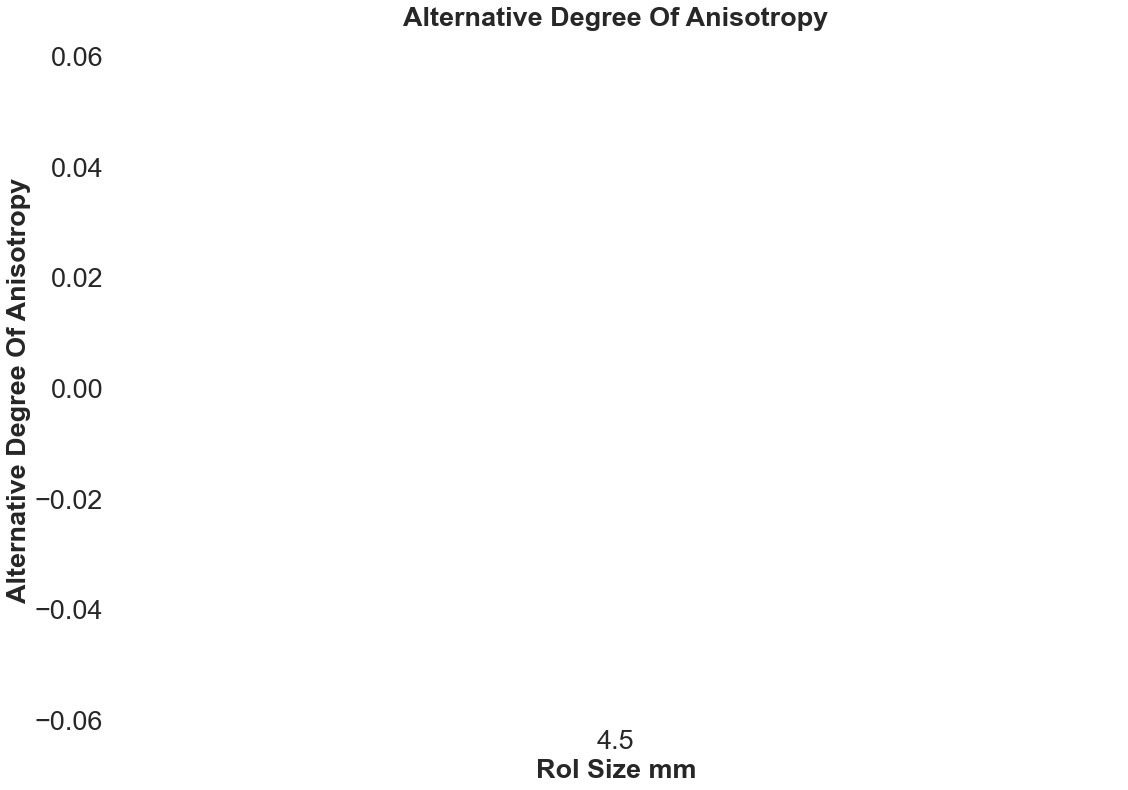

ValueError: Collections can only map rank 1 arrays

In [20]:
#transparent=True
datamatrix = pd.read_csv(os.path.join(graphResultFolder,'uCTVsCBCTResults.csv'),index_col=0)

#limitsYmax = [100,500,500,110,110,500,1e18,110,250,300,300,400,400,400,500,500,600,3.5,5.5,500,500]

varToShow = [6,7,8,12,13,14,17,18,50,51,52,60,61,62,63,64,65,66,67,69,70]

color = 'black' # Result Graphs color
boxprops = dict(linewidth=3, color=color, facecolor = 'none')
flierprops = dict(marker='o', markerfacecolor=color, markersize=12)
medianprops = dict(linewidth=2, color=color)
whiskerprops = dict(linewidth=2, color=color)

subdata =  datamatrix[datamatrix['Image origin'] == 'uCT']
lim = 0;
for var in varToShow:
    varName = subdata.columns.values[var]
    
    g = sns.factorplot( x='RoI Size mm', y = varName,
                        size = 10, aspect=1.5,\
                        data=subdata[subdata[varName].notnull()],
                        orient="v", kind='box',
                        boxprops = boxprops,
                       flierprops = flierprops,
                       medianprops = medianprops,
                       whiskerprops = whiskerprops
                      )
    
    ax = sns.stripplot(x='RoI Size mm', y = varName,
                       data=subdata[subdata[varName].notnull()],
                       size=10, jitter=True, edgecolor="gray", color = 'gray', alpha = 0.5, marker='*')

    #g.ax.set_ylim([-0.1,limitsYmax[lim]])
    lim = lim + 1
    g.ax.tick_params(axis='x', labelsize=27)
    g.ax.tick_params(axis='y', labelsize=27)
    g.ax.set_xlabel('RoI Size mm', fontsize=27,fontweight="bold")
    g.ax.set_ylabel(varName, fontsize=27,fontweight="bold")
    g.ax.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.ax.set_axis_bgcolor('white')


    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_VsRoISize_boxplot_uCT.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)
    
    g = sns.factorplot(x='RoI Size mm', y=varName, 
                        data=subdata[subdata[varName].notnull()], 
                        size = 10, aspect=1.5,\
                        color = 'gray', linewidth = 10, alpha = 0.5)
    
    g.ax.tick_params(axis='x', labelsize=27)
    g.ax.tick_params(axis='y', labelsize=27)
    g.ax.set_xlabel('RoI Size mm', fontsize=27,fontweight="bold")
    g.ax.set_ylabel(varName, fontsize=27,fontweight="bold")
    g.ax.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.ax.set_axis_bgcolor('white')
    
    
    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_VsRoISize_line_uCT.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)
    


## 6.3 Print Results uCT Vs CBCT for Jaccard and Dice

Dice
Jaccard


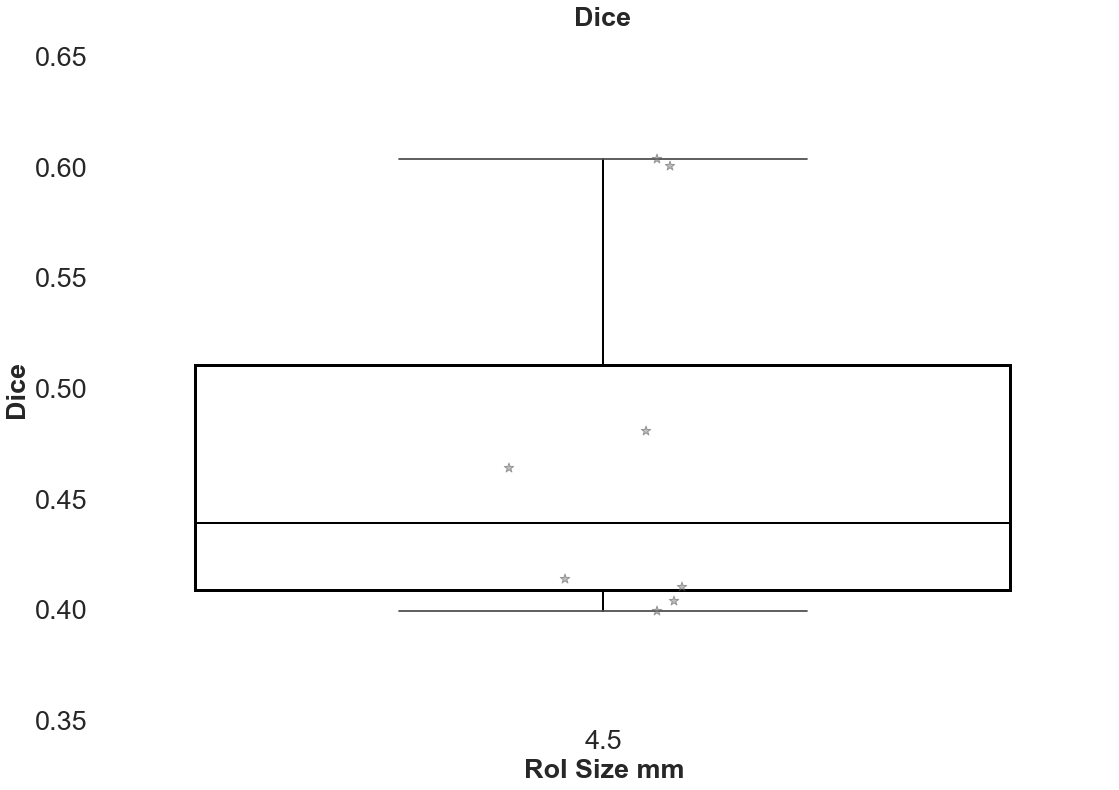

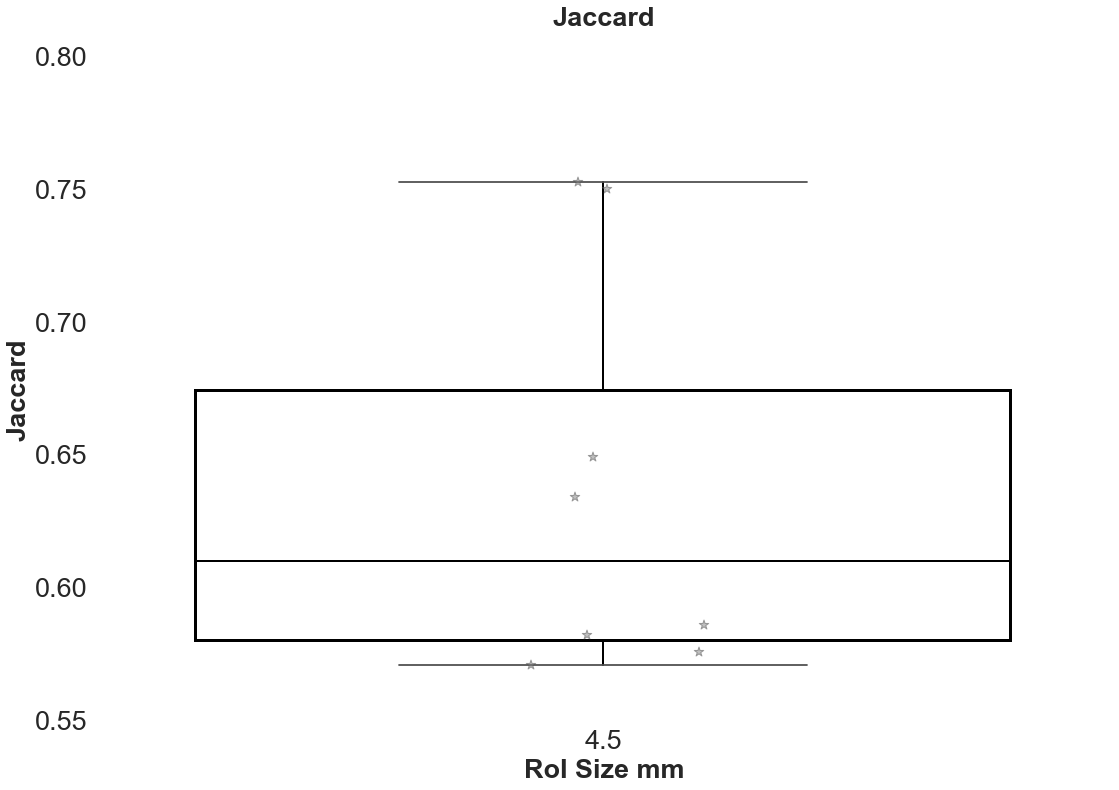

In [21]:
#transparent=True
datamatrix = pd.read_csv(os.path.join(graphResultFolder,'uCTVsCBCTResults.csv'),index_col=0)

#limitsYmax = [100,500,500,110,110,500,1e18,110,250,300,300,400,400,400,500,500,600,3.5,5.5,500,500]

varToShow = [15,20]
for var in varToShow:
    varName = subdata.columns.values[var]
    print varName

color = 'black' # Result Graphs color
boxprops = dict(linewidth=3, color=color, facecolor = 'none')
flierprops = dict(marker='o', markerfacecolor=color, markersize=12)
medianprops = dict(linewidth=2, color=color)
whiskerprops = dict(linewidth=2, color=color)

subdata =  datamatrix[datamatrix['Image origin'] == 'CBCT']
lim = 0;
for var in varToShow:
    varName = subdata.columns.values[var]
    
    g = sns.factorplot( x='RoI Size mm', y = varName,
                        size = 10, aspect=1.5,\
                        data=subdata[subdata[varName].notnull()],
                        orient="v", kind='box',
                        boxprops = boxprops,
                       flierprops = flierprops,
                       medianprops = medianprops,
                       whiskerprops = whiskerprops
                      )
    
    ax = sns.stripplot(x='RoI Size mm', y = varName,
                       data=subdata[subdata[varName].notnull()],
                       size=10, jitter=True, edgecolor="gray", color = 'gray', alpha = 0.5, marker='*')
    
    #ax = sns.factorplot(x='RoI Size mm', y=varName, data=subdata[subdata[varName].notnull()], color = 'gray', linewidth = 10, alpha = 0.5)


    #g.ax.set_ylim([-0.1,limitsYmax[lim]])
    lim = lim + 1
    g.ax.tick_params(axis='x', labelsize=27)
    g.ax.tick_params(axis='y', labelsize=27)
    g.ax.set_xlabel('RoI Size mm', fontsize=27,fontweight="bold")
    g.ax.set_ylabel(varName, fontsize=27,fontweight="bold")
    g.ax.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.ax.set_axis_bgcolor('white')


    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_VsRoISize.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)


## 6.4 Print Results uCT Vs RoI localization

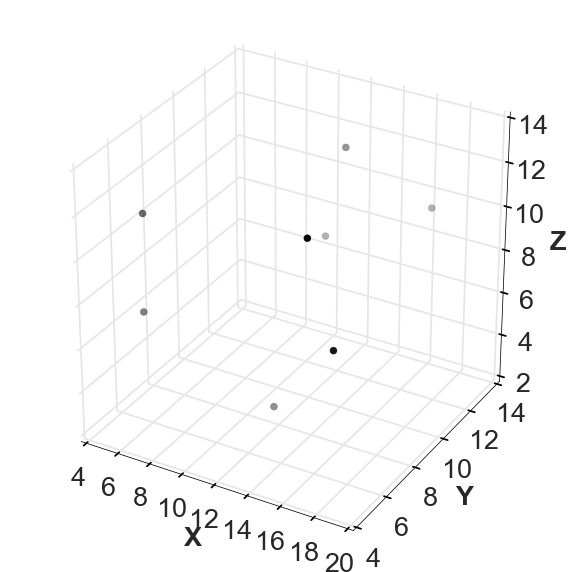

In [22]:
# To measure the RoI localization we calculate the projection to the PCA bigger axis

datamatrix = pd.read_csv(os.path.join(graphResultFolder,'uCTVsCBCTResults.csv'),index_col=0)

# Get only uCT data
datamatrix = datamatrix[datamatrix['Image origin'] == 'uCT']

# Get X, Y and Z 

xpoints = datamatrix['Center x mm'].values
ypoints = datamatrix['Center y mm'].values
zpoints = datamatrix['Center z mm'].values

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpoints, ypoints, zpoints, c='black', marker='o', s = 50)
ax.set_xlabel('X', fontsize=27,fontweight="bold")
ax.set_ylabel('Y', fontsize=27,fontweight="bold")
ax.set_zlabel('Z', fontsize=27,fontweight="bold")
ax.set_axis_bgcolor('white')
ax.tick_params(axis='x', labelsize=27, color = color)
ax.tick_params(axis='y', labelsize=27, color = color)
ax.tick_params(axis='z', labelsize=27, color = color)
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# Save results
resultfile = graphResultFolder + r'/RoICenters3D.png'
plt.savefig(resultfile,bbox_inches='tight',transparent=True)

# Calculate PCA
import sklearn.decomposition as deco

Point = np.concatenate(([xpoints],[ypoints],[zpoints]), axis = 0).T

Point = (Point - np.mean(Point, 0)) / np.std(Point, 0) # You need to normalize your data first
pca = deco.PCA(3) # n_components is the components number after reduction
x_r = pca.fit(Point).transform(Point)

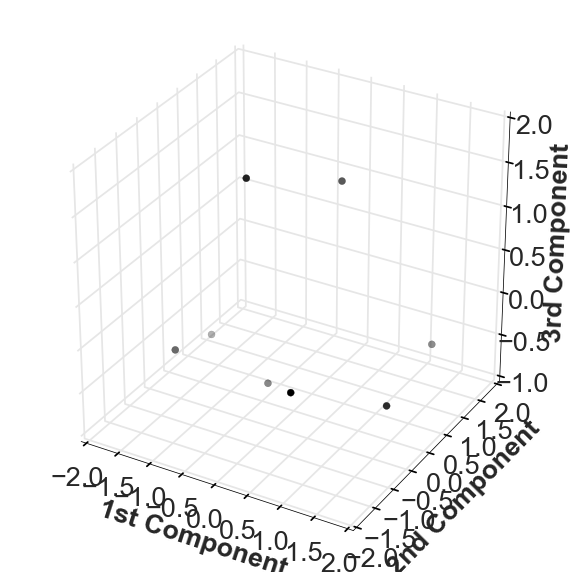

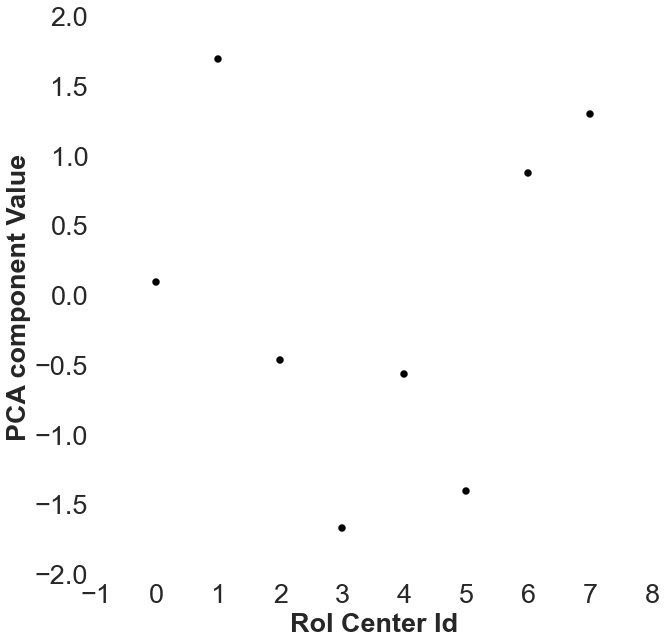

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_r[:,0], x_r[:,1], x_r[:,2], c='black', marker='o', s = 50)
ax.set_xlabel('1st Component', fontsize=27,fontweight="bold")
ax.set_ylabel('2nd Component', fontsize=27,fontweight="bold")
ax.set_zlabel('3rd Component', fontsize=27,fontweight="bold")
ax.set_axis_bgcolor('white')
ax.tick_params(axis='x', labelsize=27, color = color)
ax.tick_params(axis='y', labelsize=27, color = color)
ax.tick_params(axis='z', labelsize=27, color = color)
ax.w_xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.w_zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# Save results
resultfile = graphResultFolder + r'/RoICenters_PCA.png'
plt.savefig(resultfile,bbox_inches='tight',transparent=True)



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(range(len(x_r[:,0])), x_r[:,0],  c='black', marker='o', s = 50)
ax.set_xlabel('RoI Center Id', fontsize=27,fontweight="bold")
ax.set_ylabel('PCA component Value', fontsize=27,fontweight="bold")
ax.set_axis_bgcolor('white')
ax.tick_params(axis='x', labelsize=27, color = color)
ax.tick_params(axis='y', labelsize=27, color = color)
# Save results
resultfile = graphResultFolder + r'/FirstPCAComponentRoICenters.png'
plt.savefig(resultfile,bbox_inches='tight',transparent=True)


In [24]:
datamatrix['RoI Localization'] = x_r[:,0]

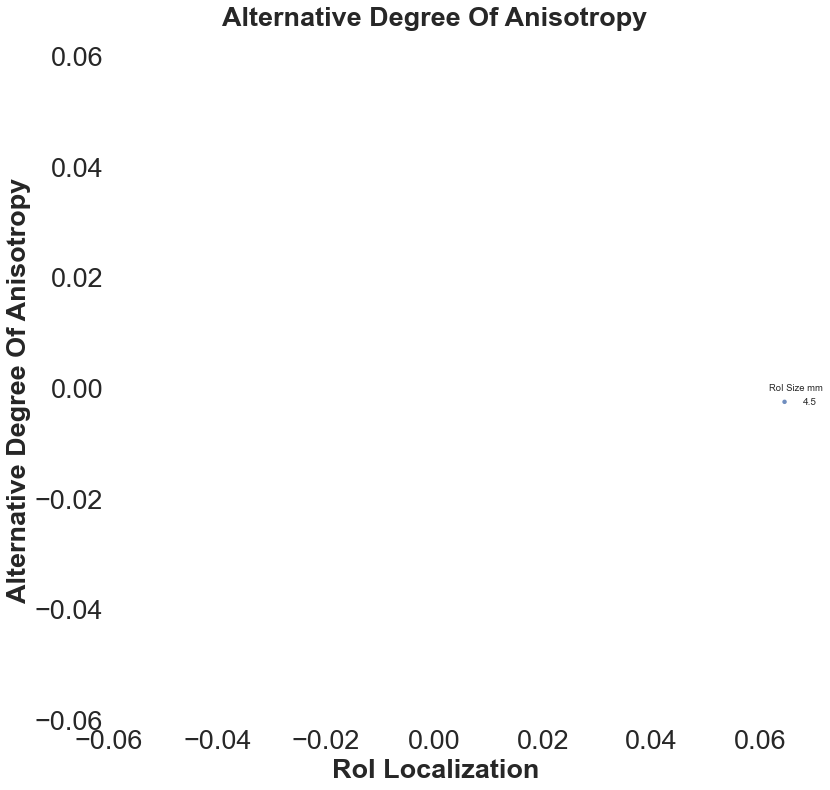

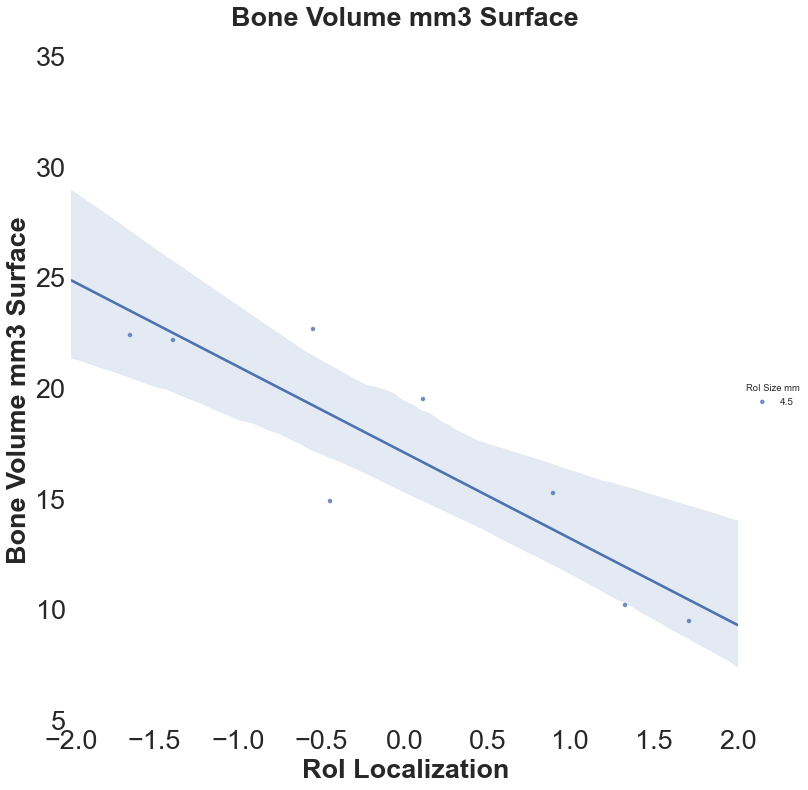

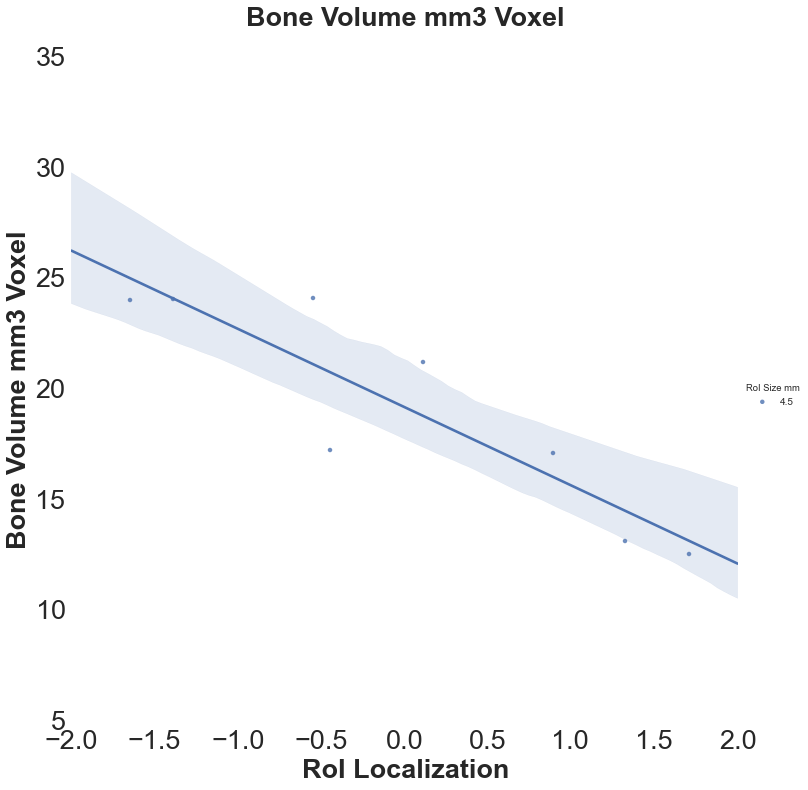

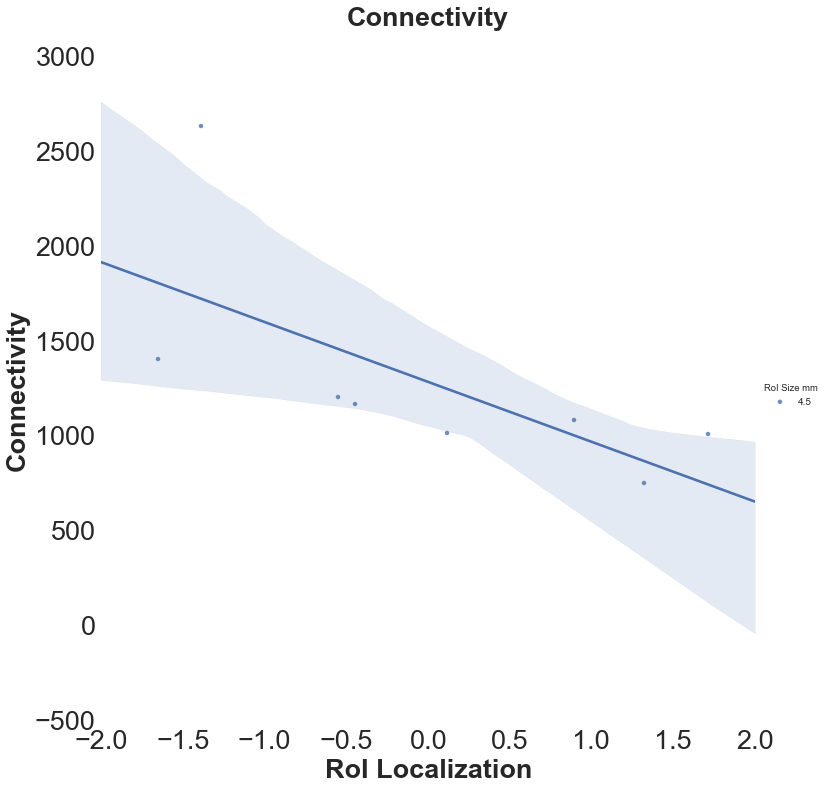

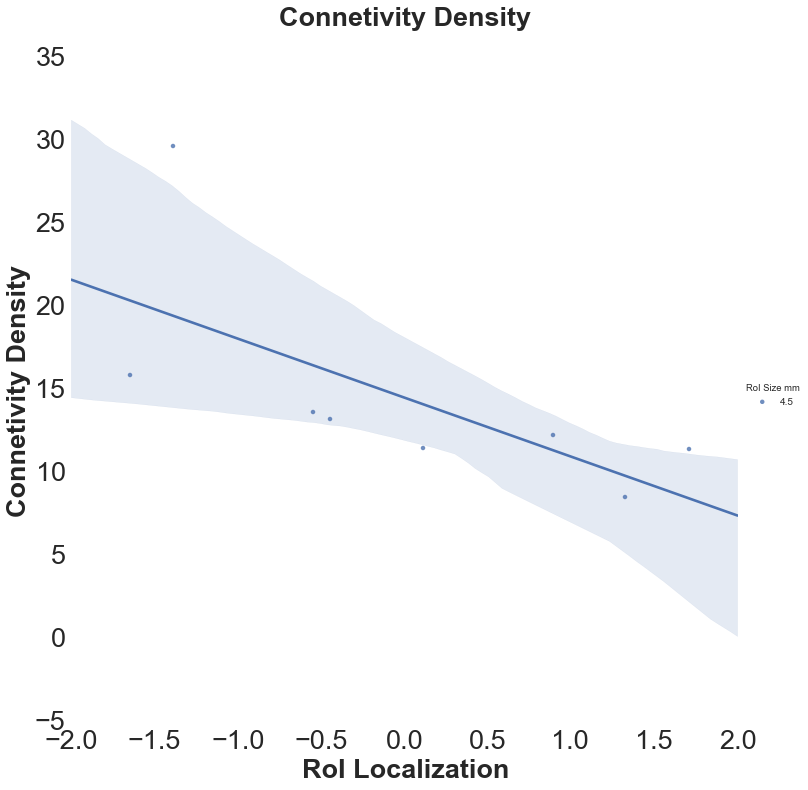

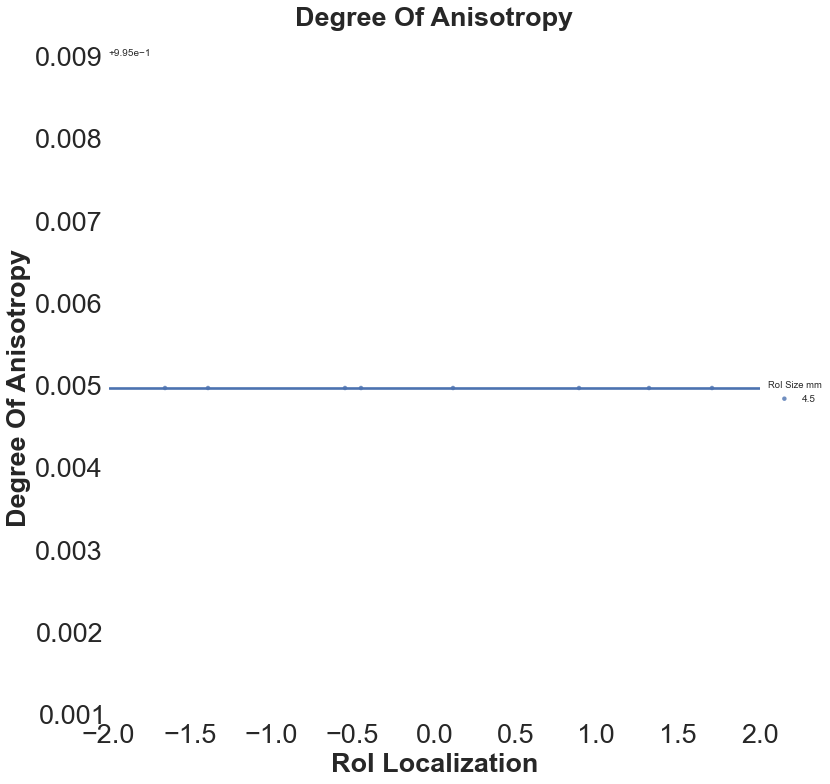

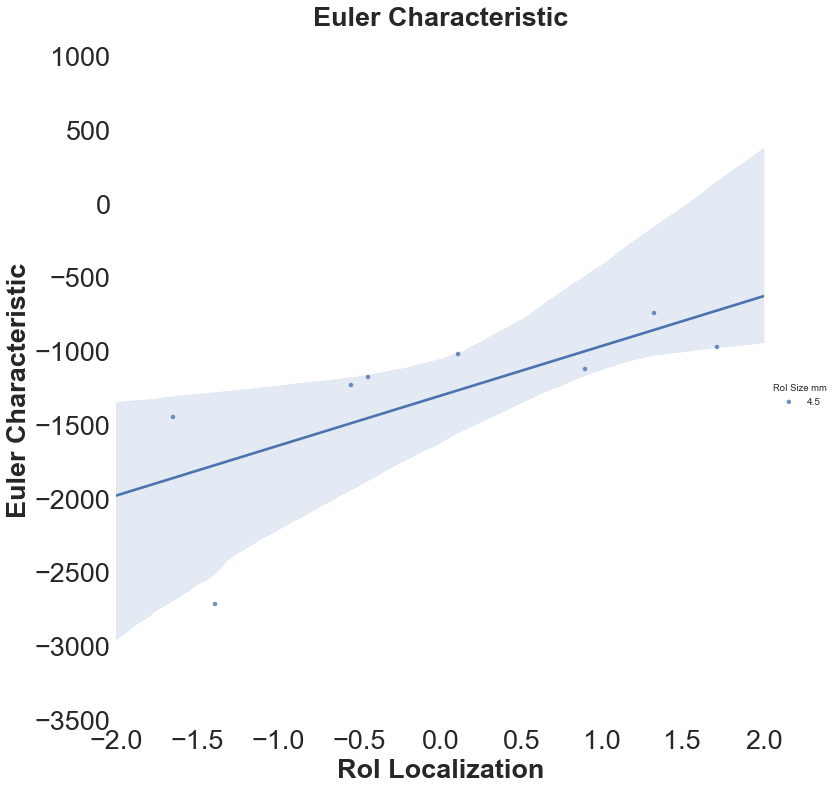

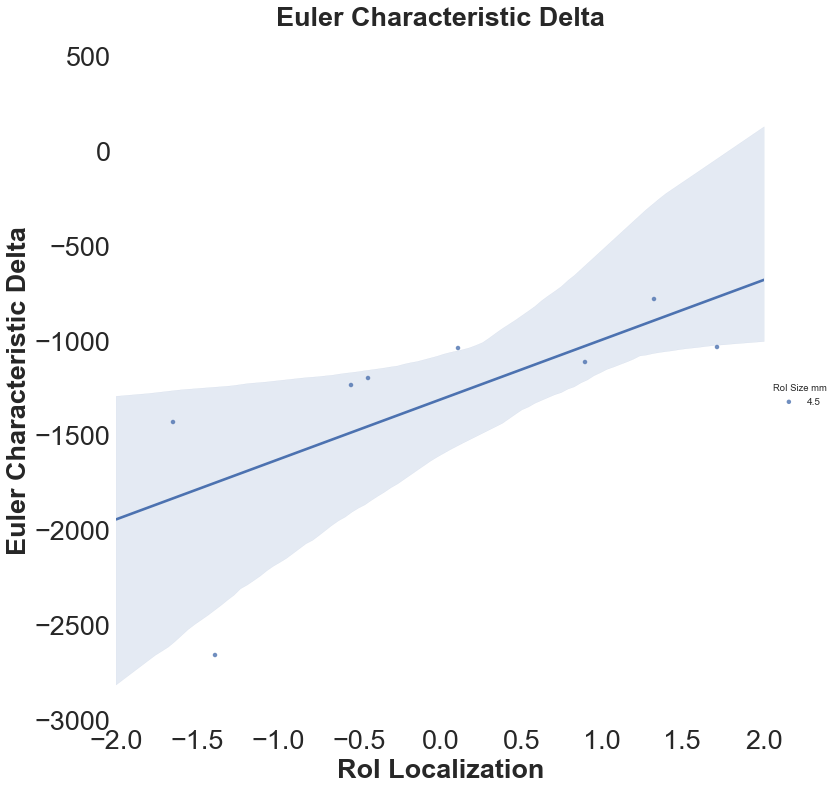

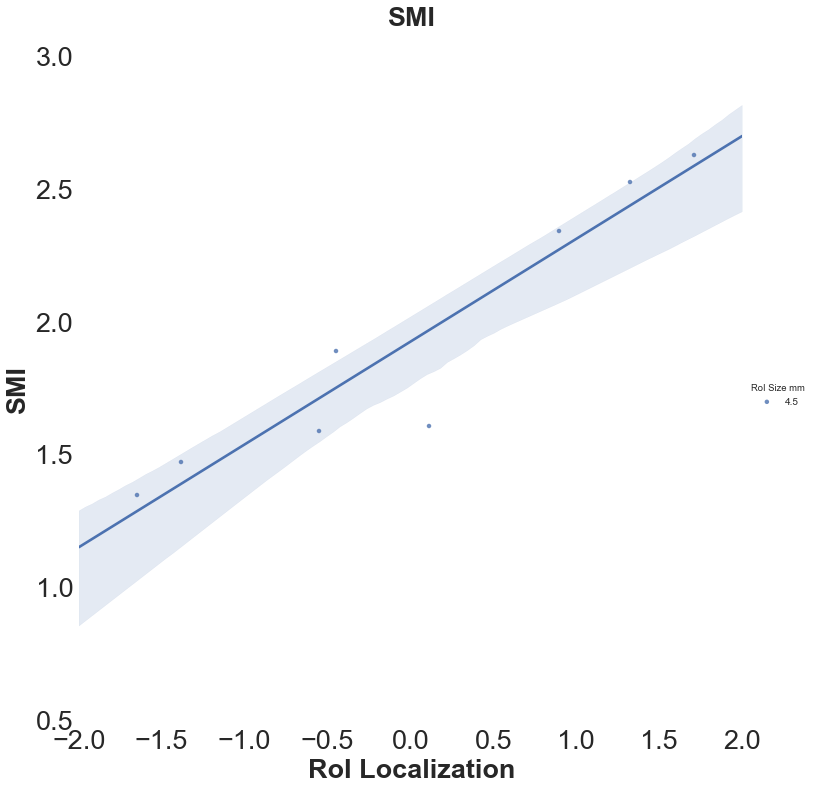

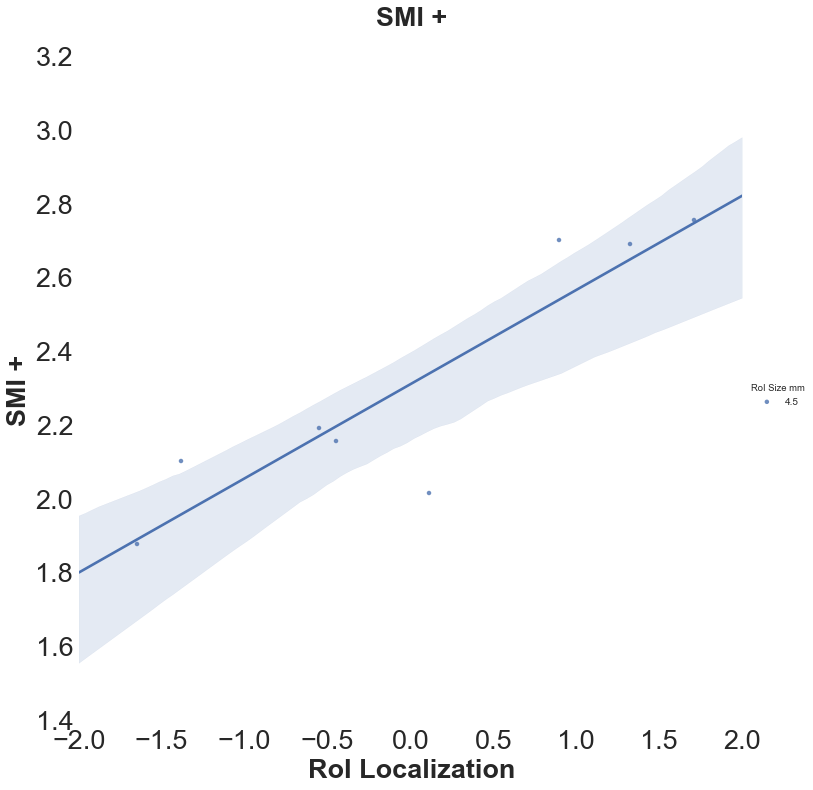

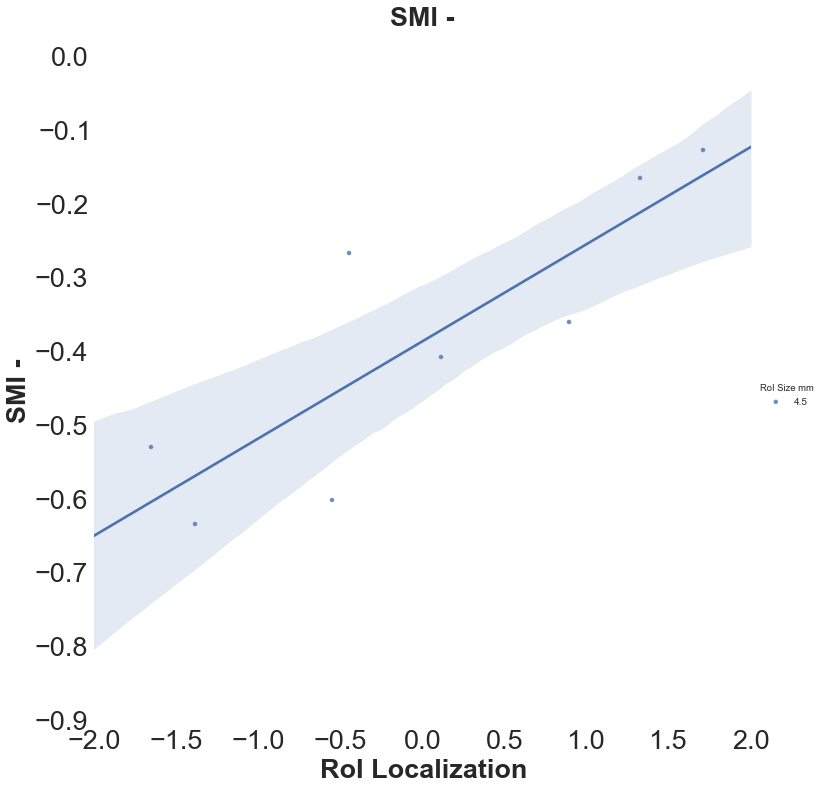

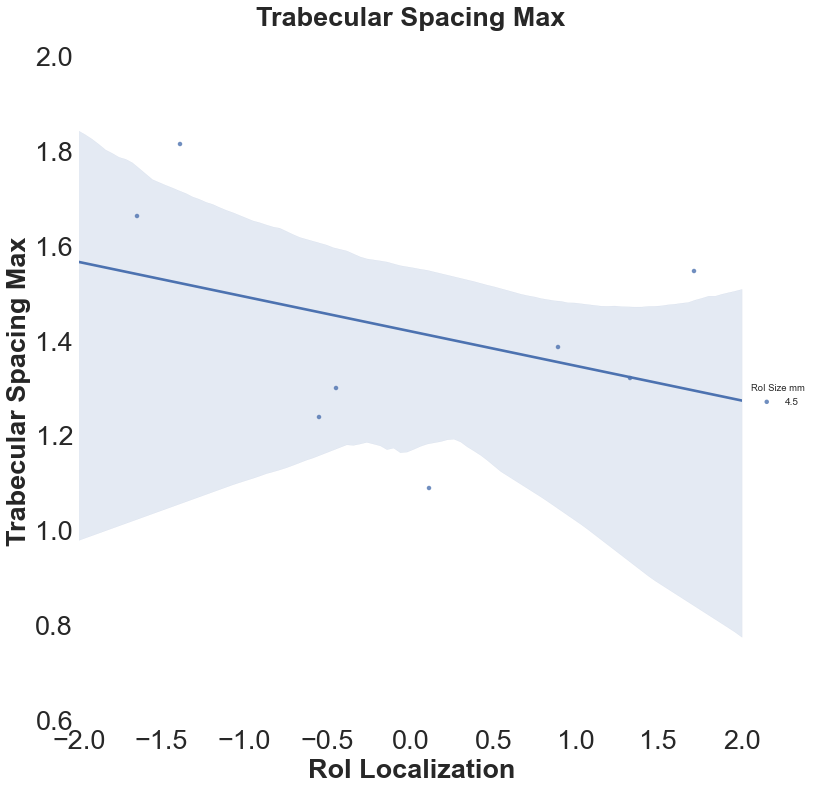

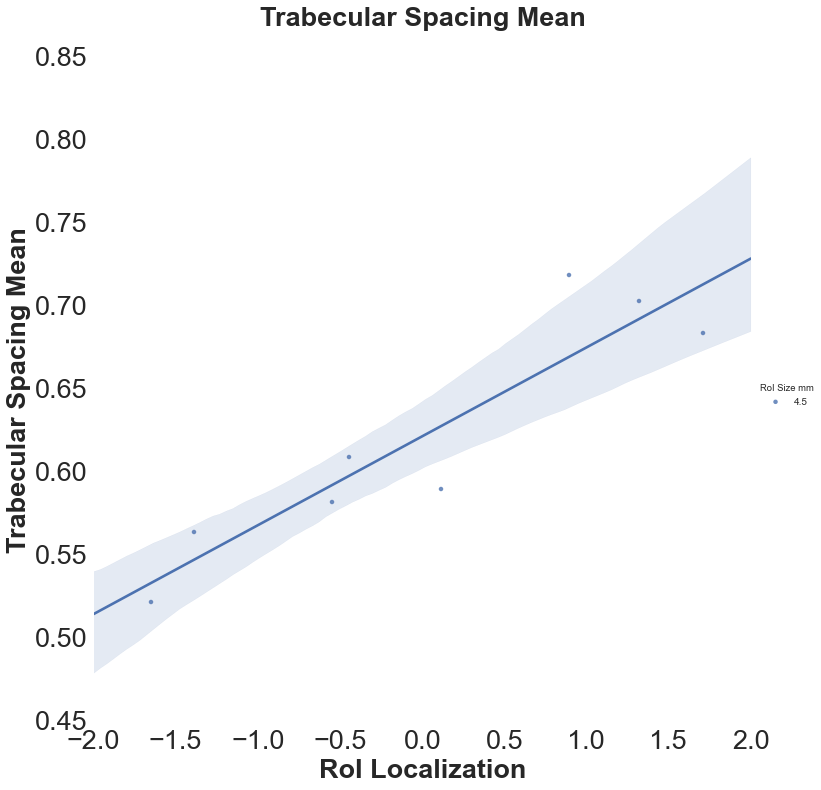

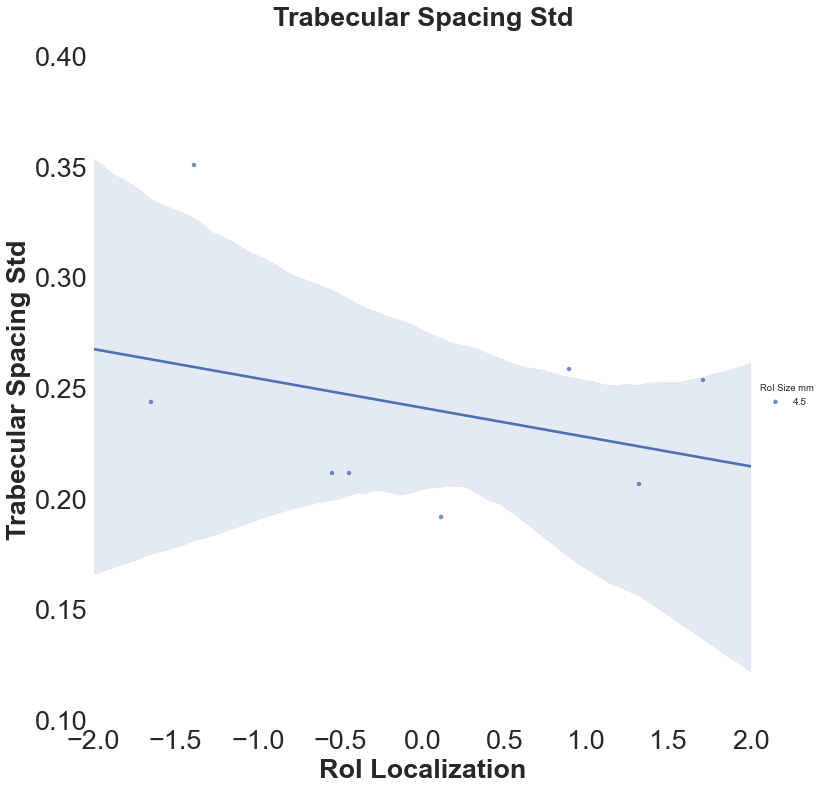

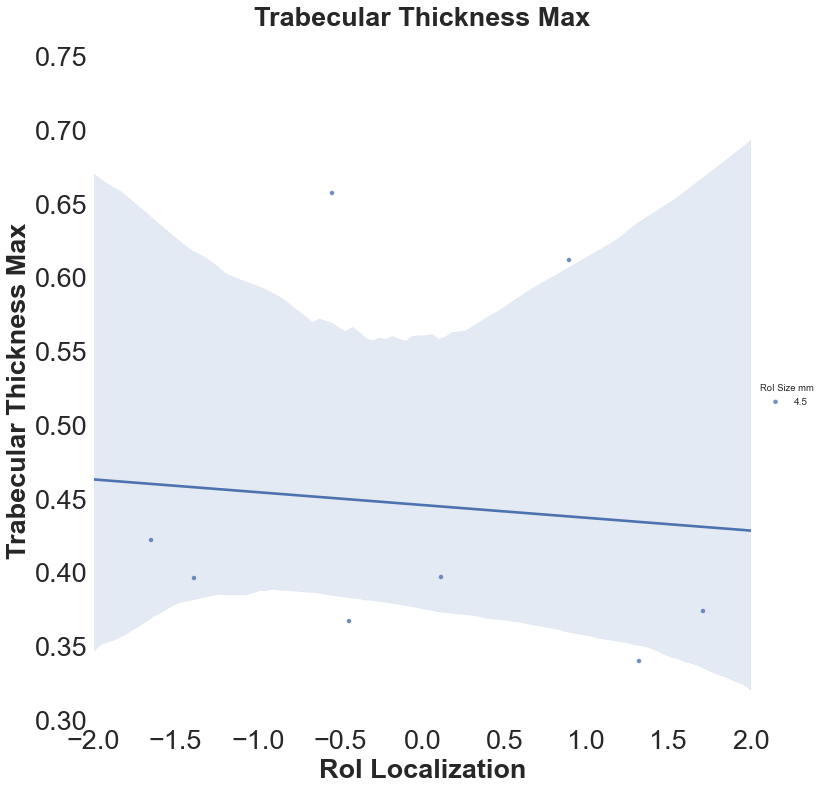

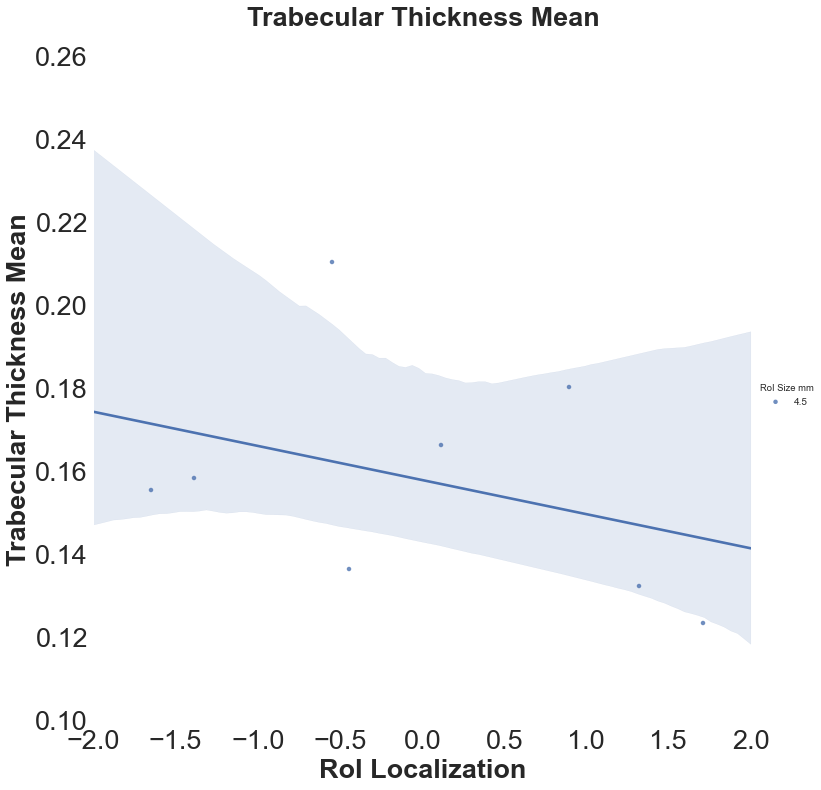

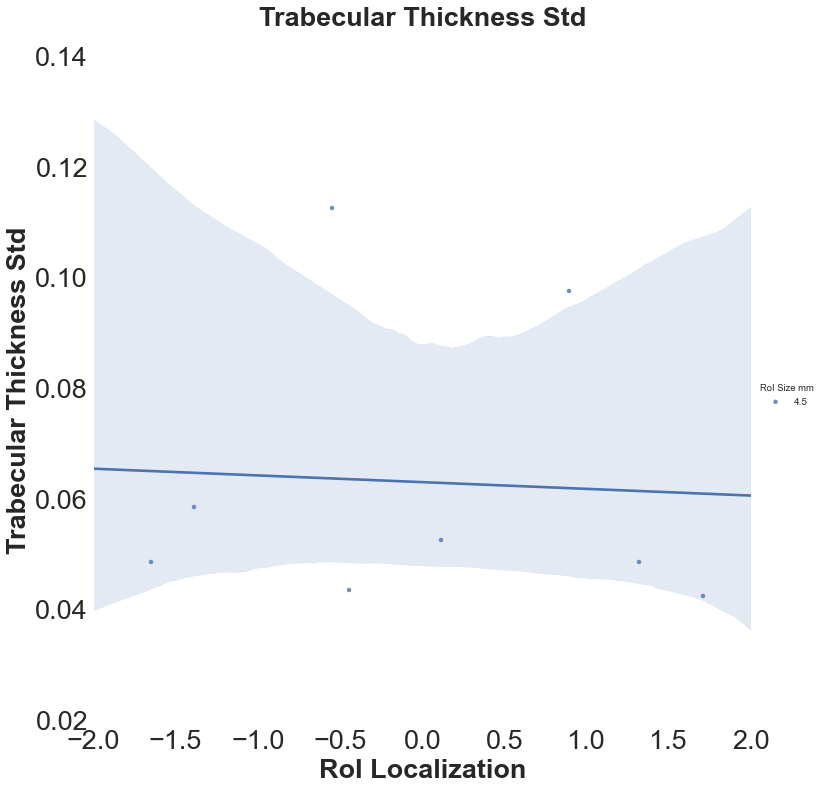

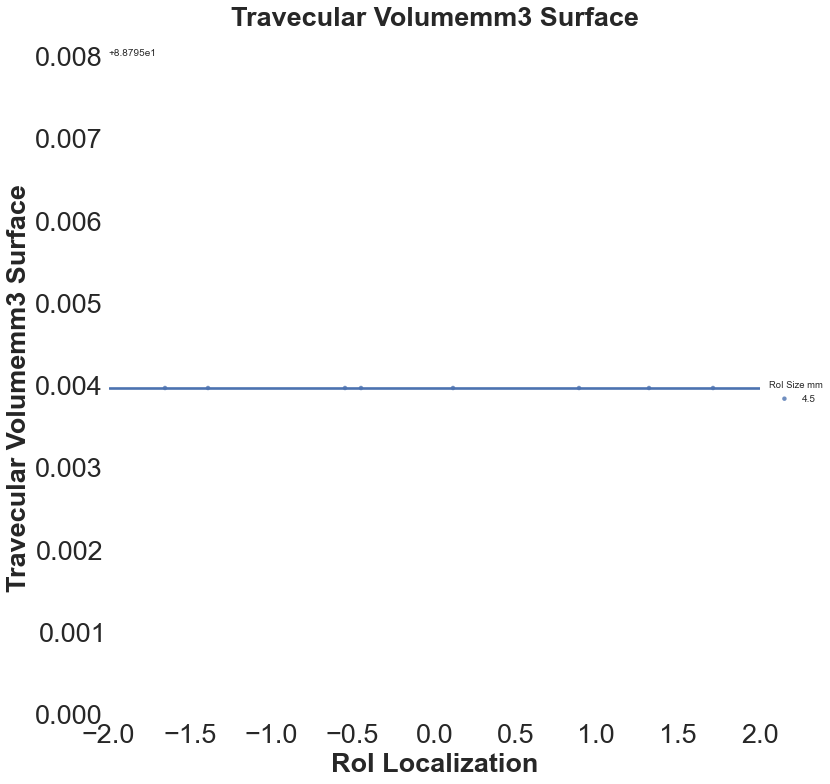

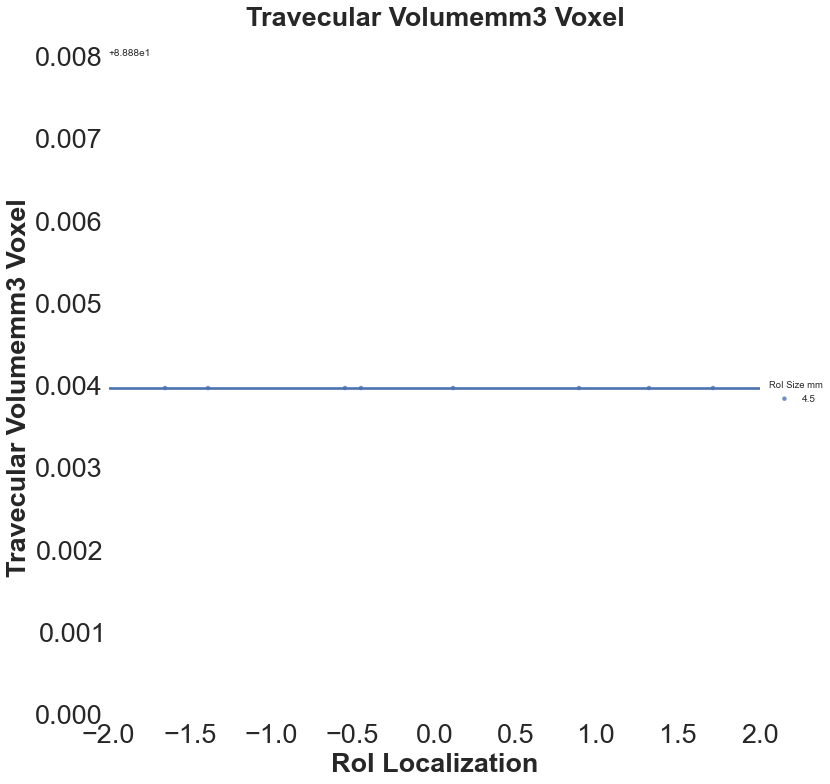

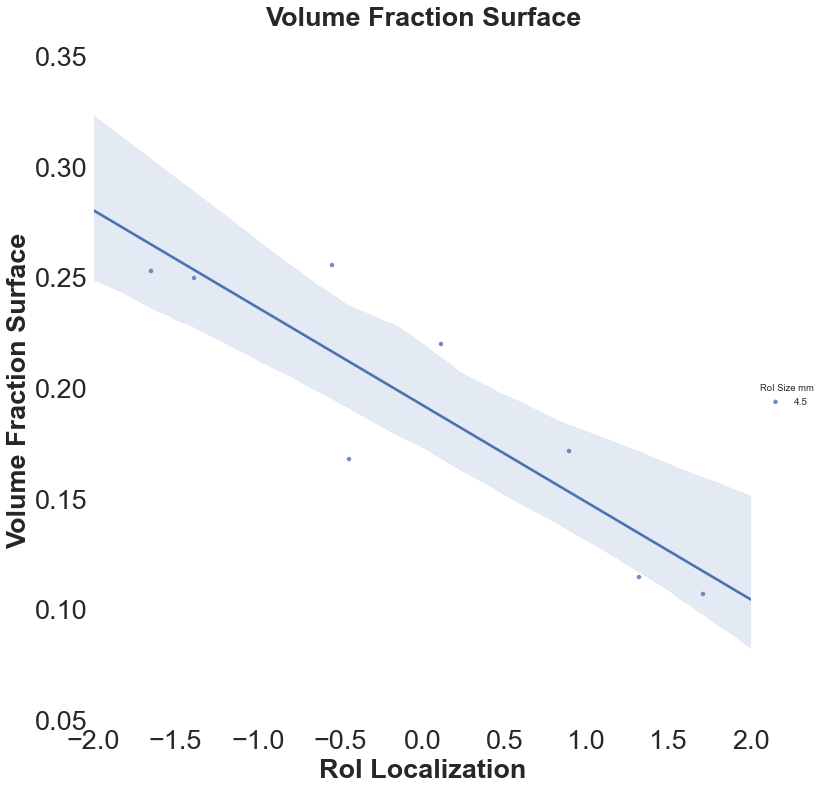

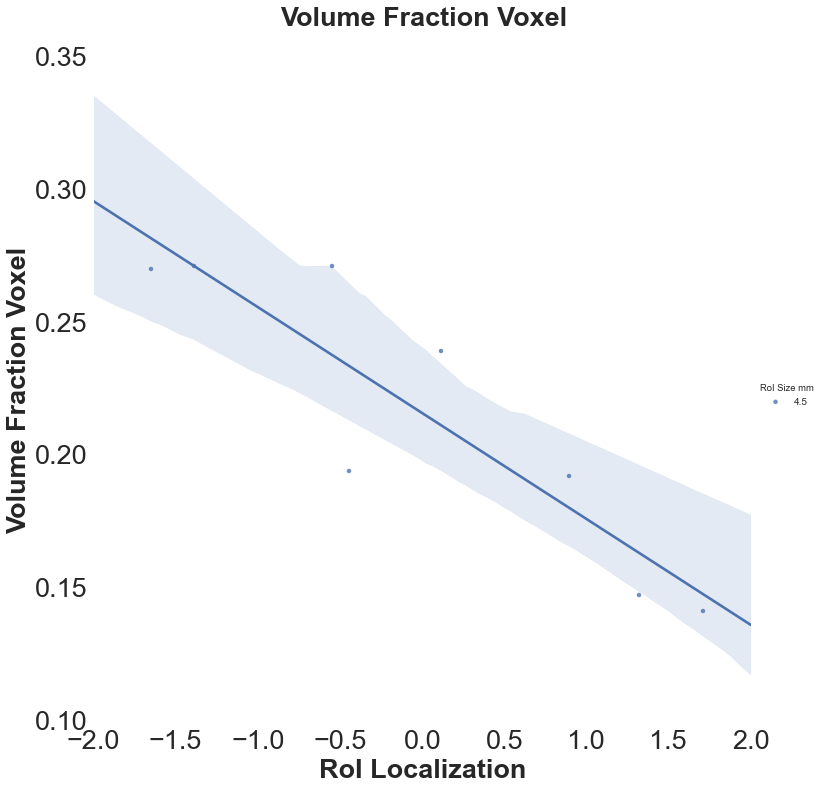

In [30]:
varToShow =[6,7,8,12,13,14,17,18,50,51,52,60,61,62,63,64,65,66,67,69,70]

color = 'black' # Result Graphs color
boxprops = dict(linewidth=3, color=color, facecolor = 'none')
flierprops = dict(marker='o', markerfacecolor=color, markersize=12)
medianprops = dict(linewidth=2, color=color)
whiskerprops = dict(linewidth=2, color=color)

subdata =  datamatrix[datamatrix['Image origin'] == 'uCT']
lim = 0;
for var in varToShow:
    varName = subdata.columns.values[var]
    fig = plt.figure(figsize=(25, 15))
    data = subdata[subdata[varName].notnull()]
    g = sns.lmplot(x='RoI Localization', y=varName, data=data, hue="RoI Size mm",
                    scatter_kws = {'s' : 20}, size = 10, aspect = 1)
    
    #g.ax.set_ylim([-0.1,np.percentile(data[varName], 80)])
    lim = lim + 1
    g.ax.tick_params(axis='x', labelsize=27)
    g.ax.tick_params(axis='y', labelsize=27)
    g.ax.set_xlabel('RoI Localization', fontsize=27,fontweight="bold")
    g.ax.set_ylabel(varName, fontsize=27,fontweight="bold")
    g.ax.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.ax.set_axis_bgcolor('white')


    # Save results
    resultfile = graphResultFolder + r'/'+varName+'VsRoILocalization_uCT.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)


## 6.5 Print Results uCT vs CBCT

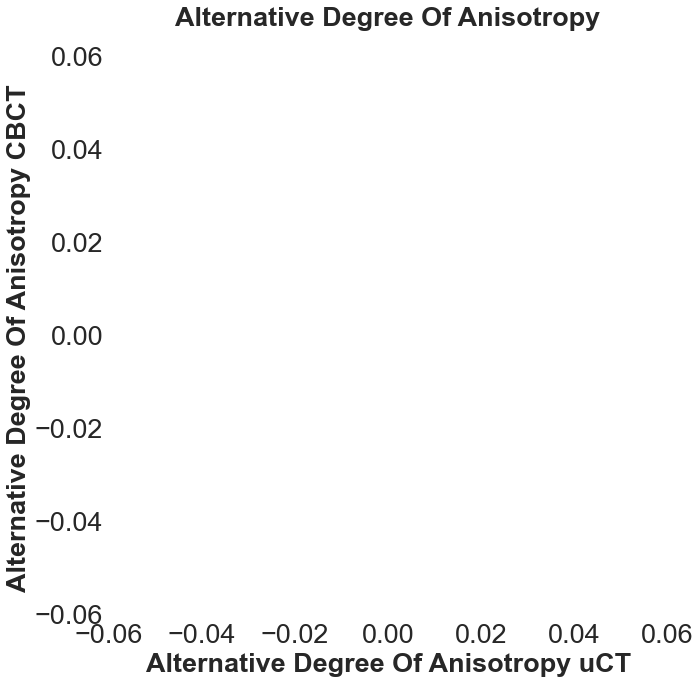

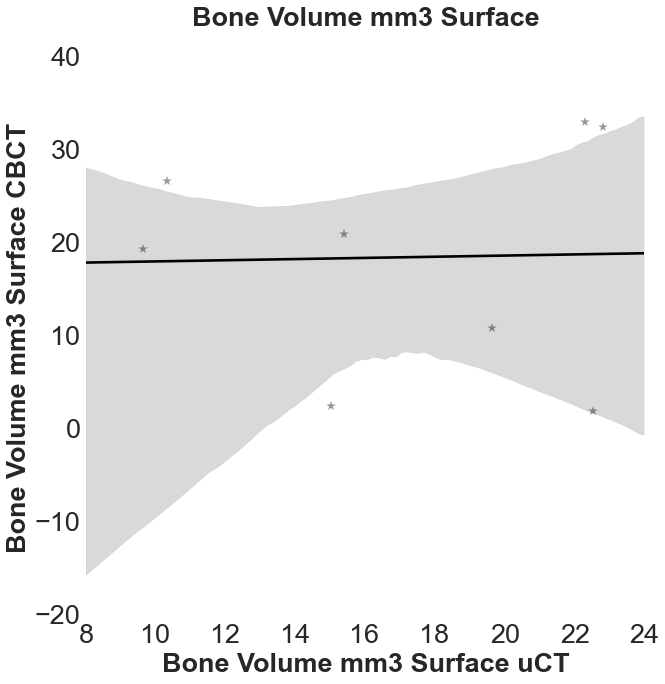

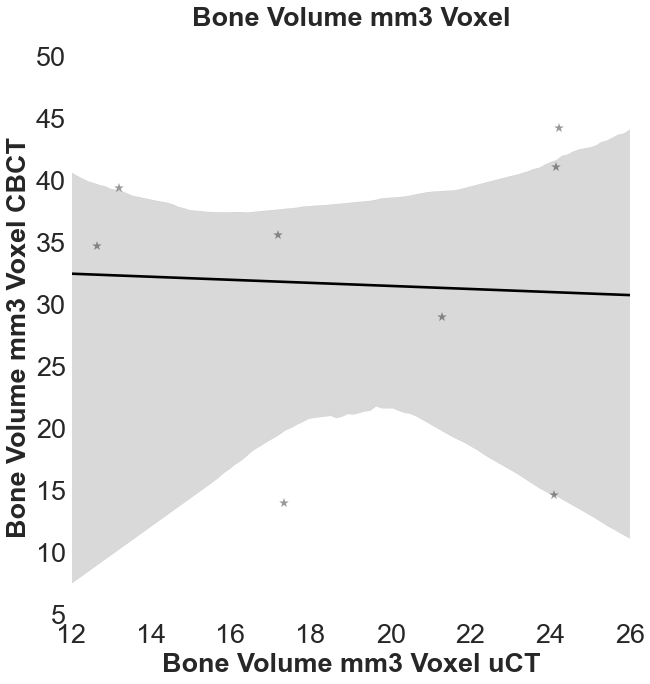

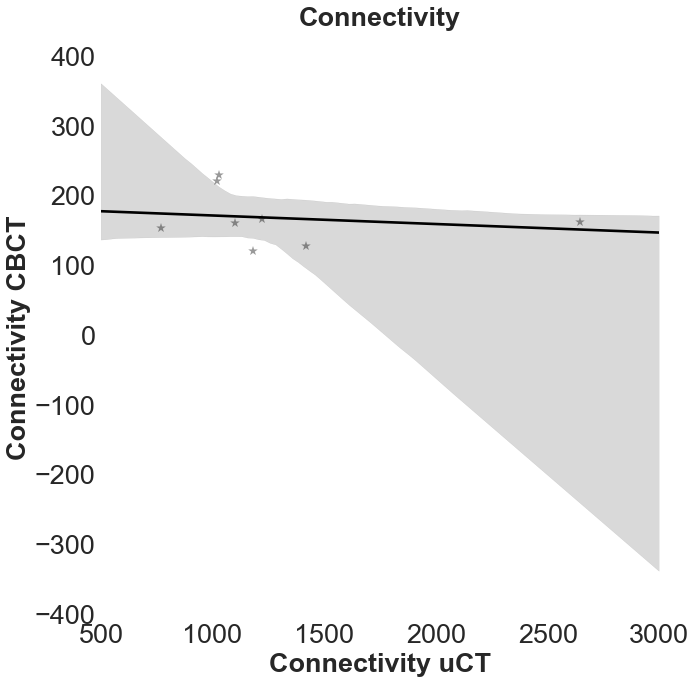

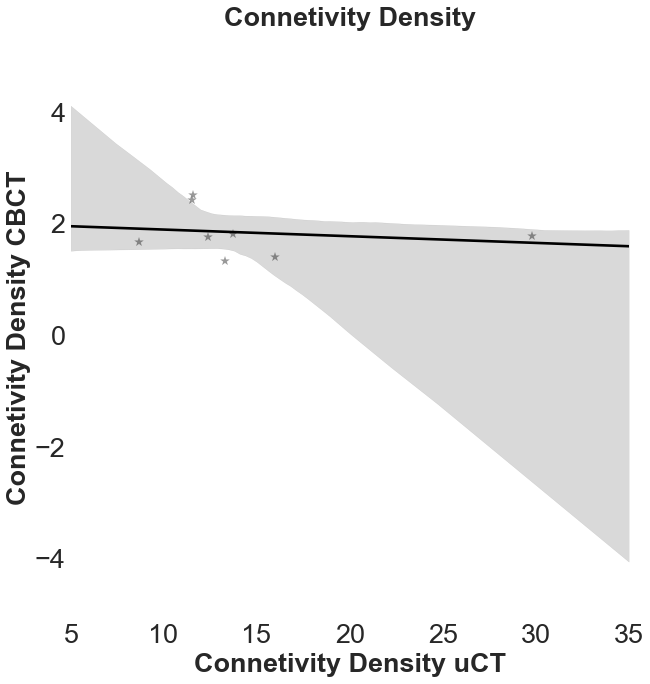

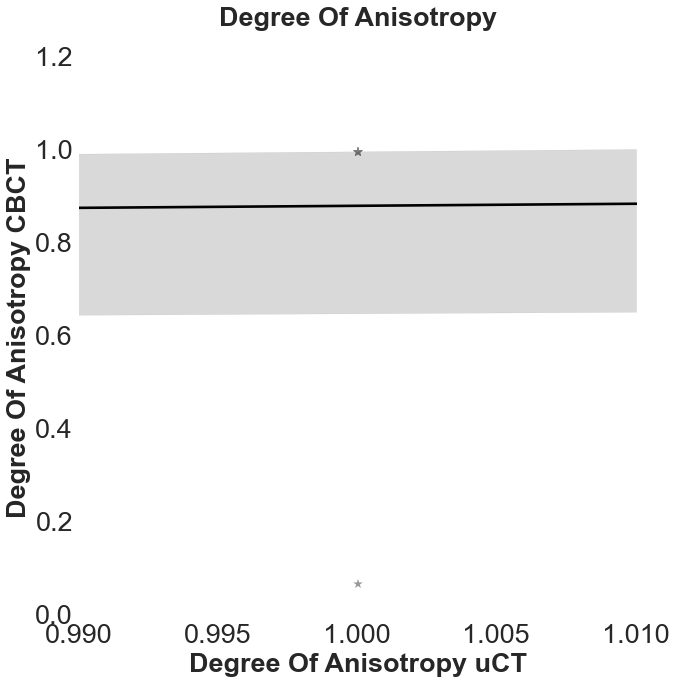

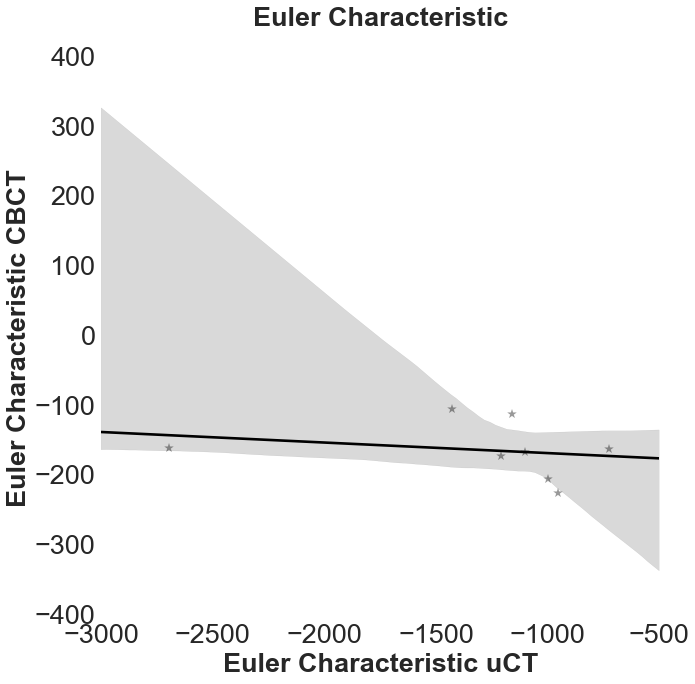

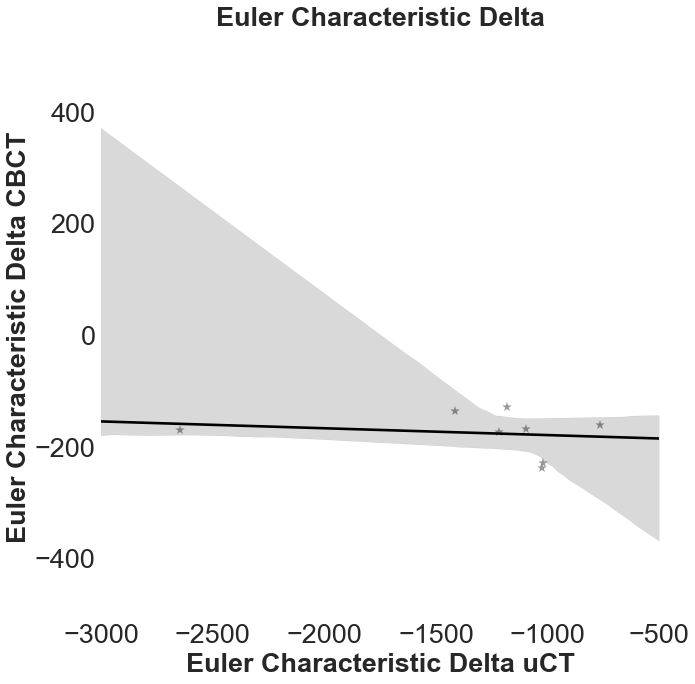

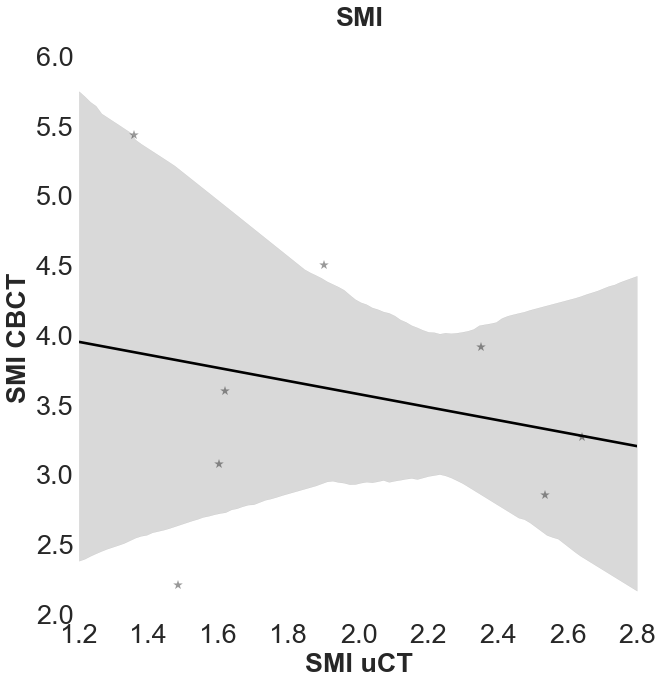

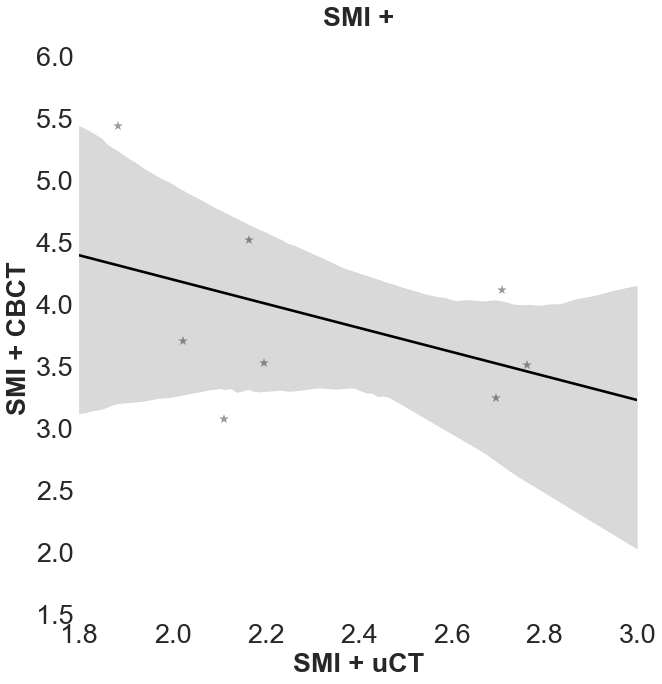

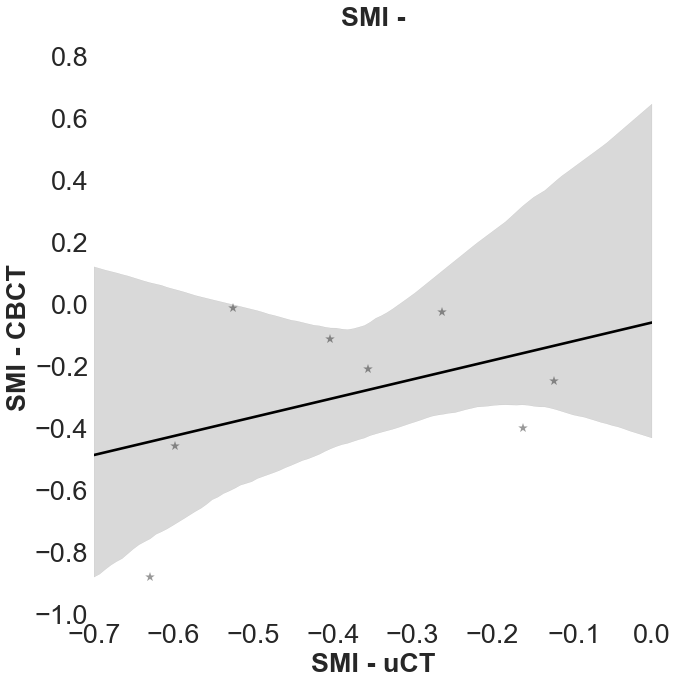

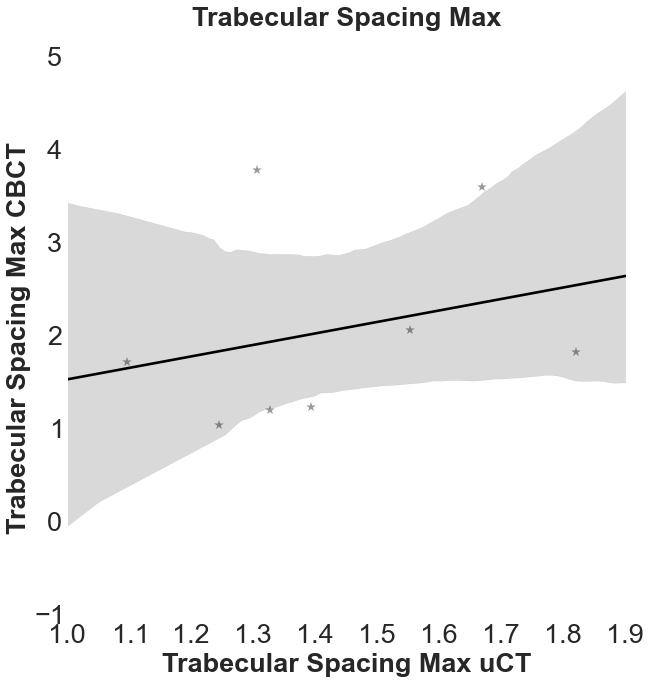

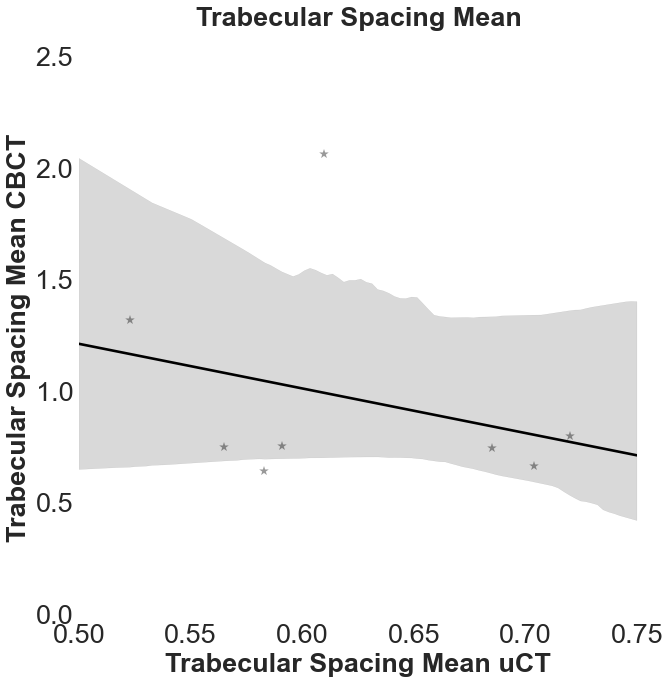

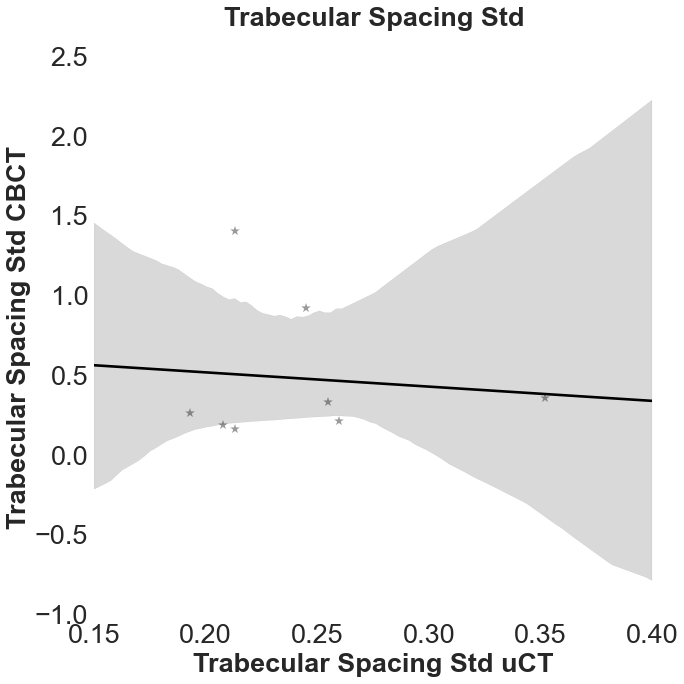

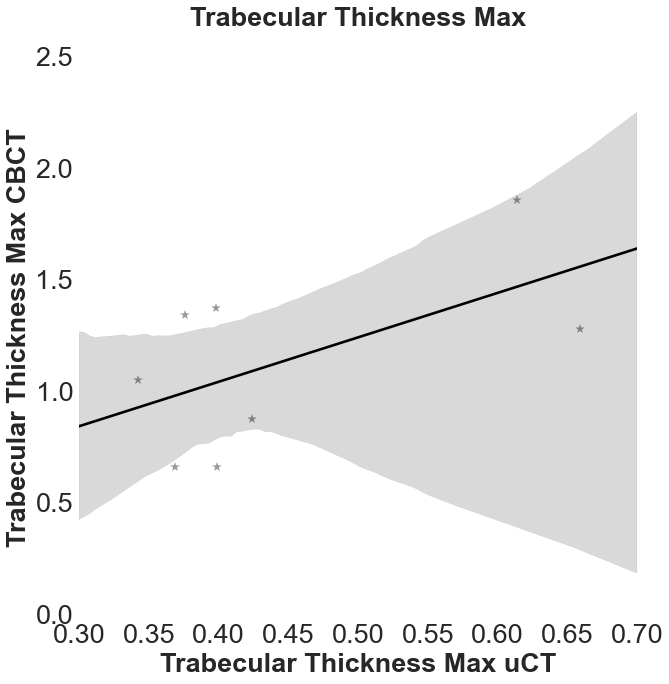

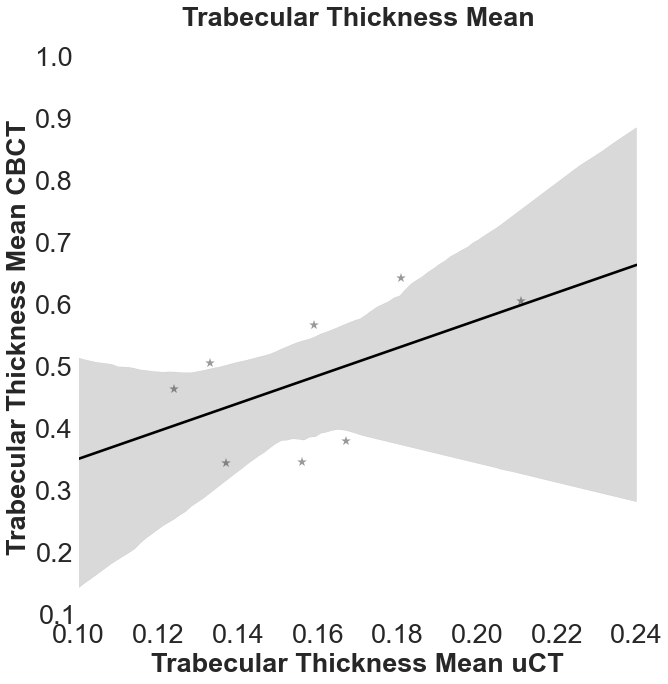

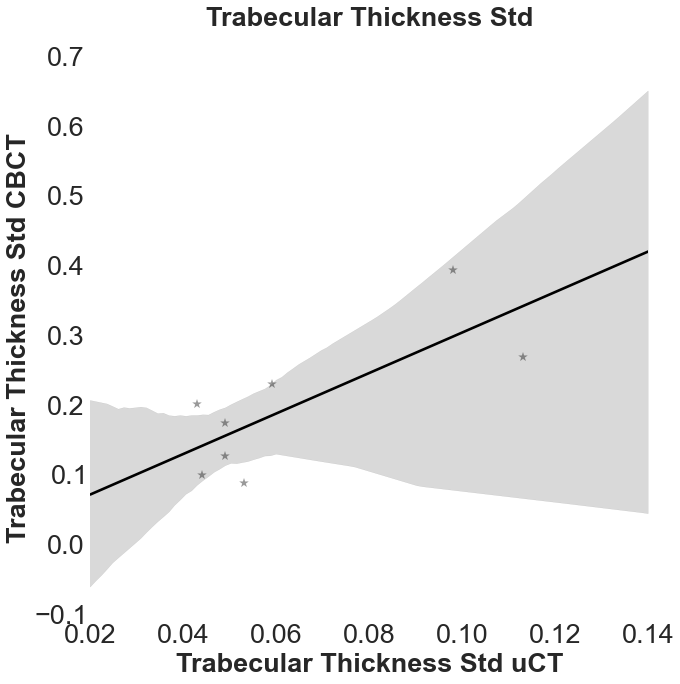

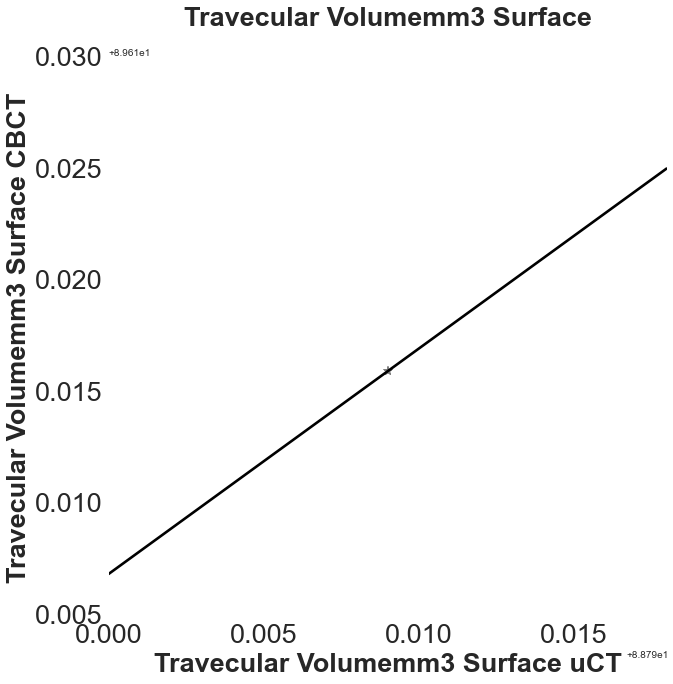

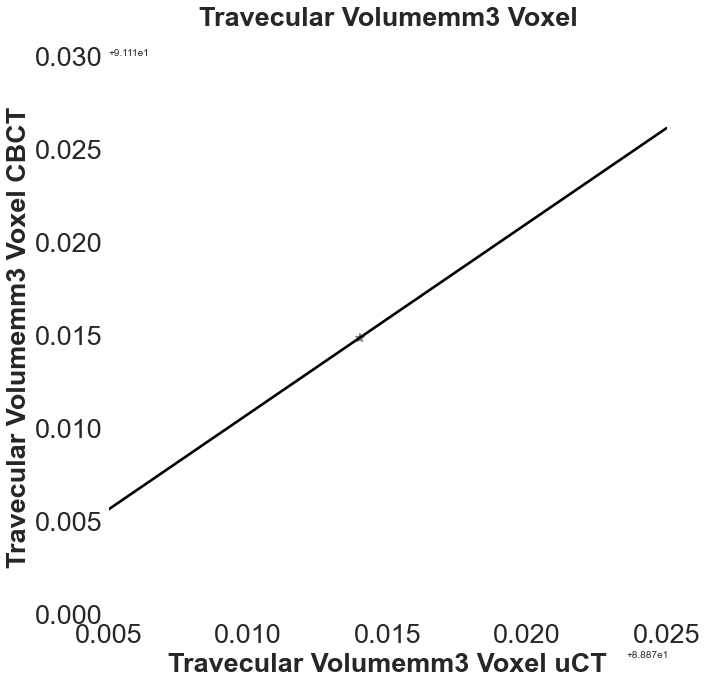

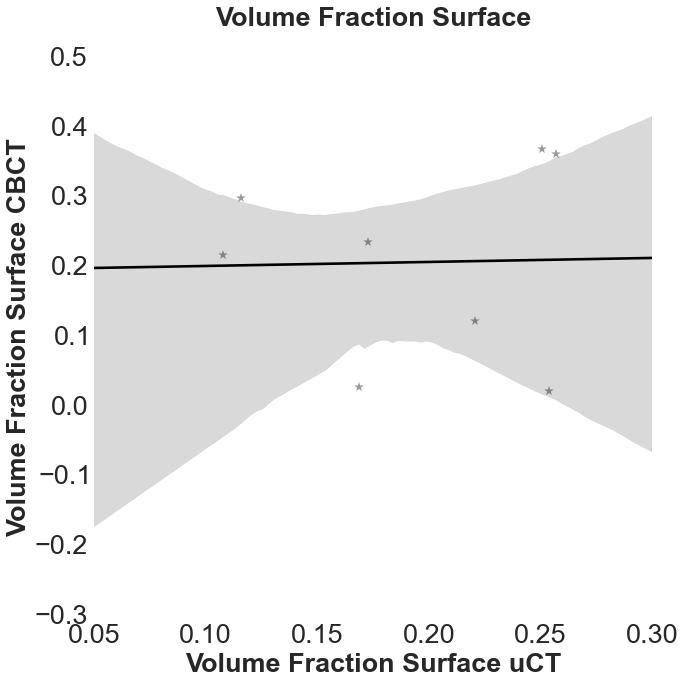

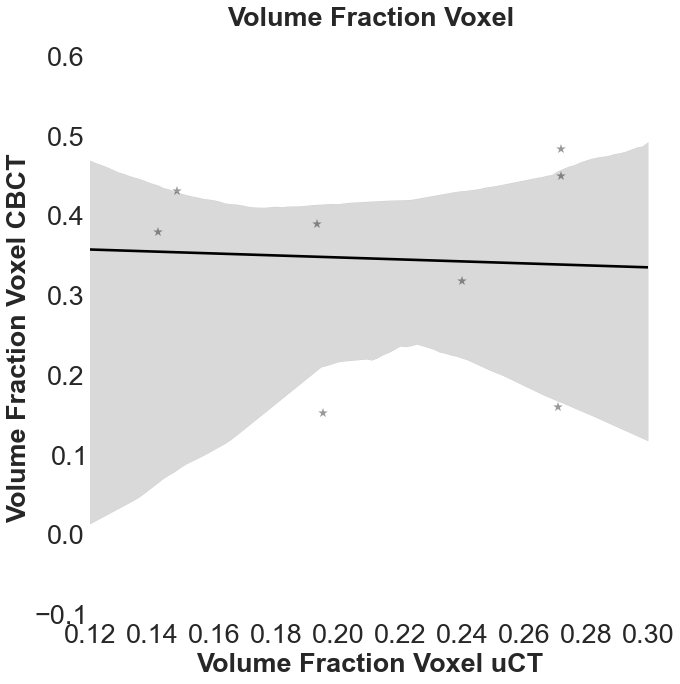

In [31]:
datamatrix = pd.read_csv(os.path.join(graphResultFolder,'uCTVsCBCTResults.csv'),index_col=0)


varToShow = [6,7,8,12,13,14,17,18,50,51,52,60,61,62,63,64,65,66,67,69,70]


for var in varToShow:

    varName = datamatrix.columns.values[var]
    data = datamatrix.loc[:,('Image origin', varName, 'RoI Size mm','RoI Number')]
    subdata = data[data['Image origin'] == 'CBCT']
    #Var_CBCT = Var_CBCT[varName]

    Var_uCT = data[data['Image origin'] == 'uCT']
    #Var_uCT = Var_uCT[varName]

    subdata = subdata.sort_values(by = ['RoI Size mm','RoI Number'])
    Var_uCT = Var_uCT.sort_values(by = ['RoI Size mm','RoI Number'])

    subdata['uCTData'] = Var_uCT[varName]



    fig = plt.figure(figsize=(10, 10))
    data = subdata[subdata[varName].notnull() & subdata['uCTData'].notnull()]
    g = sns.regplot(x='uCTData', y=varName, data=data,
                    color = 'black',marker = '*', scatter_kws = {'s' : 100, 'color' : 'gray'})

    #g.ax.set_ylim([-0.1,np.percentile(data[varName], 80)])
    lim = lim + 1
    g.tick_params(axis='x', labelsize=27)
    g.tick_params(axis='y', labelsize=27)
    g.set_xlabel(varName + ' uCT', fontsize=27,fontweight="bold")
    g.set_ylabel(varName + ' CBCT', fontsize=27,fontweight="bold")
    g.set_title(varName + '\n', fontsize=27,fontweight="bold")
    g.set_axis_bgcolor('white')


    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_uCTVsCBCT_Scatter.png'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)




# Results for conference

In [72]:
for i, e in enumerate(datamatrix.columns):
    print i, e

0 ANISOTROPY_MaxSpheres
1 ANISOTROPY_MinSpheres
2 ANISOTROPY_Radius
3 ANISOTROPY_Tol
4 ANISOTROPY_VectorSampling
5 ANISOTROPY_Vectors
6 Alternative Degree Of Anisotropy
7 Bone Volume mm3 Surface
8 Bone Volume mm3 Voxel
9 Center x mm
10 Center y mm
11 Center z mm
12 Connectivity
13 Connetivity Density
14 Degree Of Anisotropy
15 Dice
16 Distance to zero
17 Euler Characteristic
18 Euler Characteristic Delta
19 Image origin
20 Jaccard
21 Matching
22 Number of Dilations
23 Number of Erosions
24 Origin RoI
25 Relative Error Alternative Degree Of Anisotropy
26 Relative Error Bone Volume mm3 Surface
27 Relative Error Bone Volume mm3 Voxel
28 Relative Error Connectivity
29 Relative Error Connetivity Density
30 Relative Error Degree Of Anisotropy
31 Relative Error Euler Characteristic
32 Relative Error Euler Characteristic Delta
33 Relative Error SMI
34 Relative Error SMI +
35 Relative Error SMI -
36 Relative Error Trabecular Spacing Max
37 Relative Error Trabecular Spacing Mean
38 Relative Erro

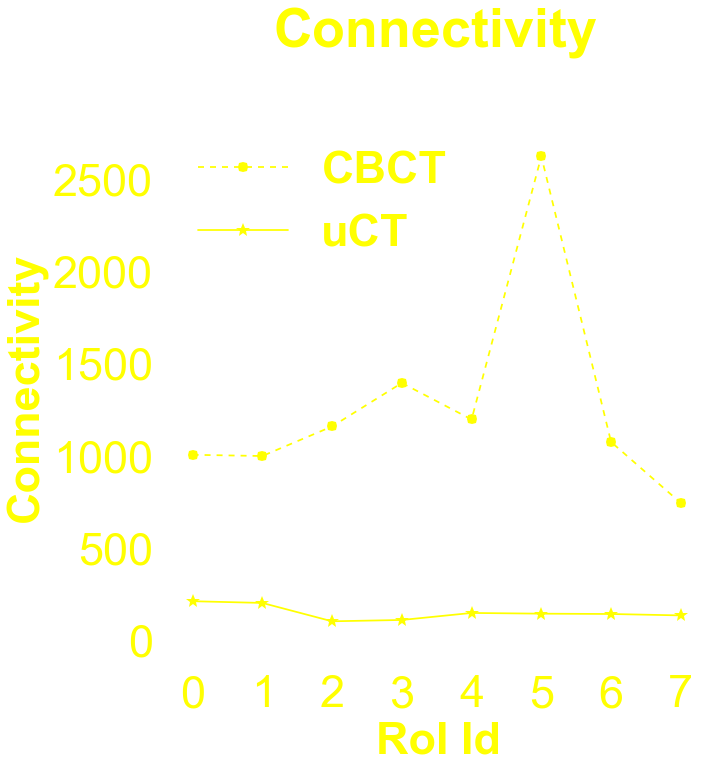

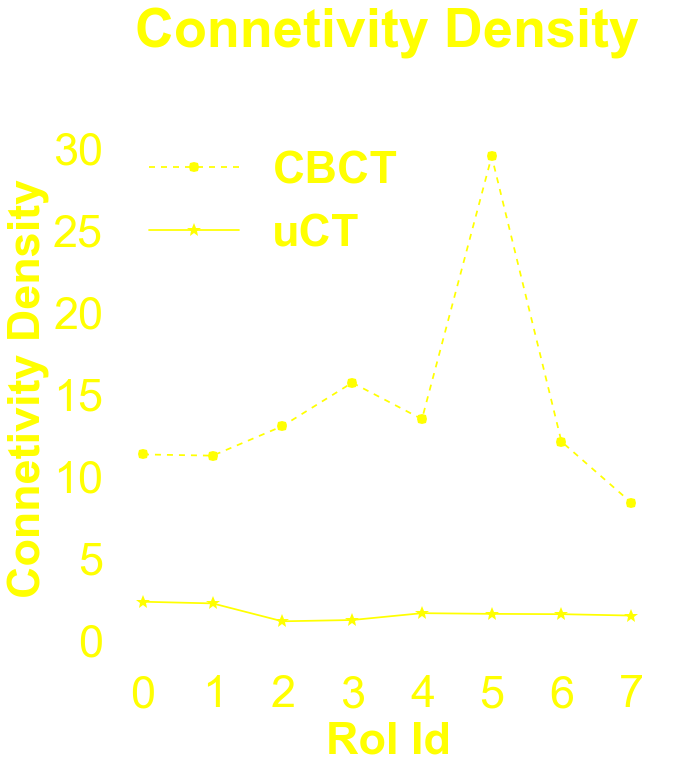

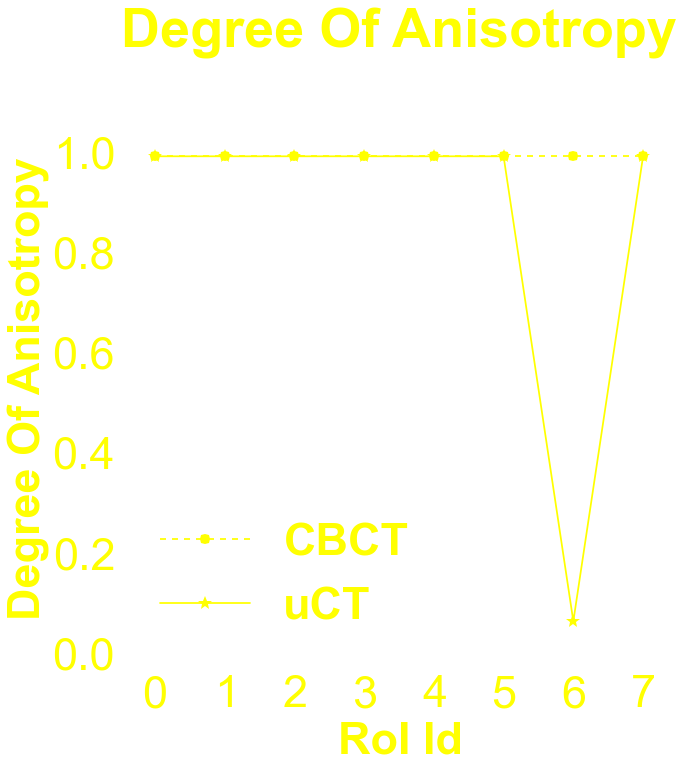

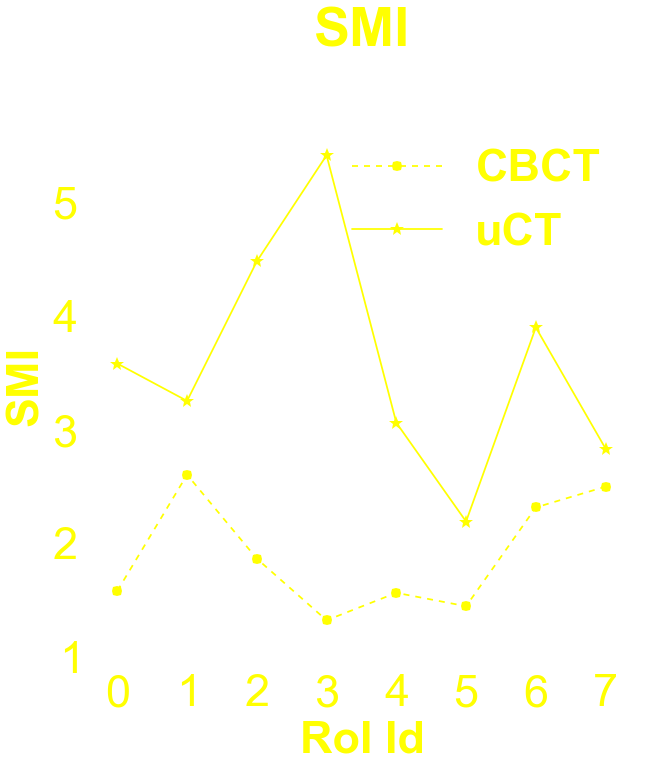

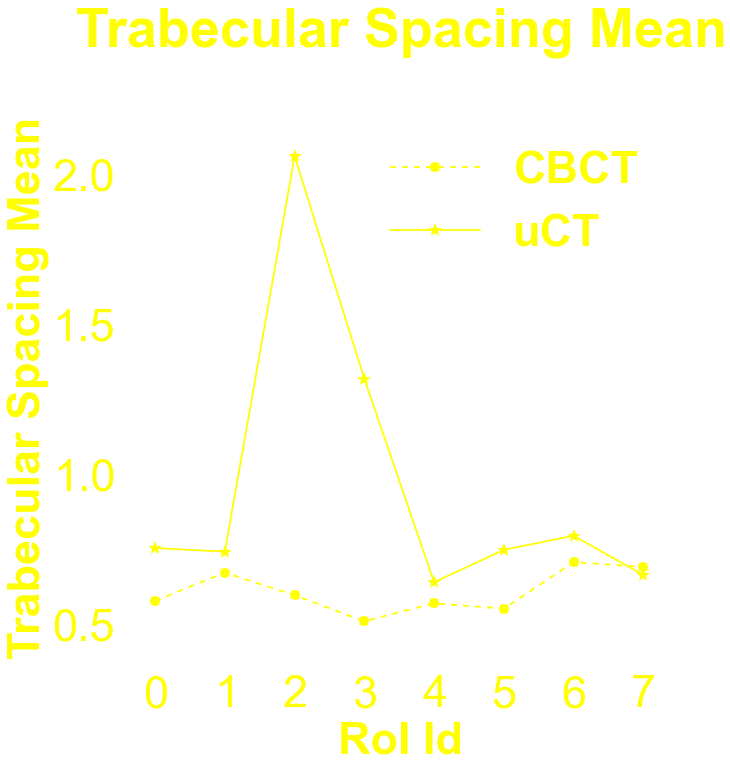

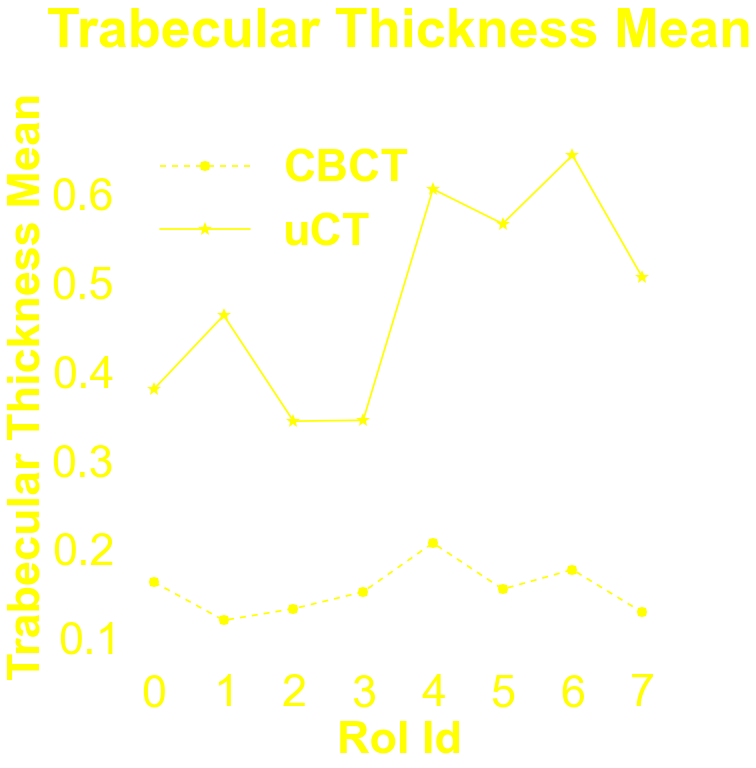

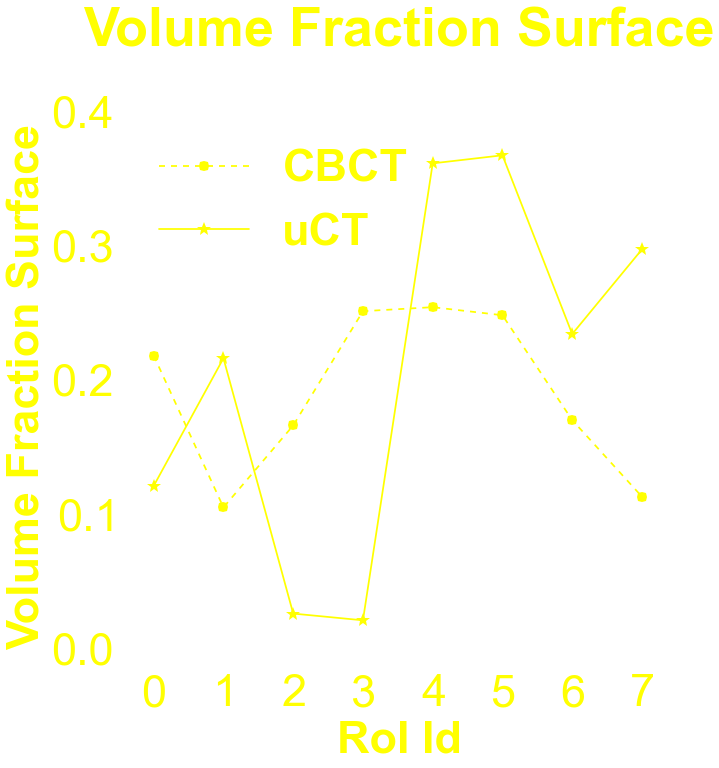

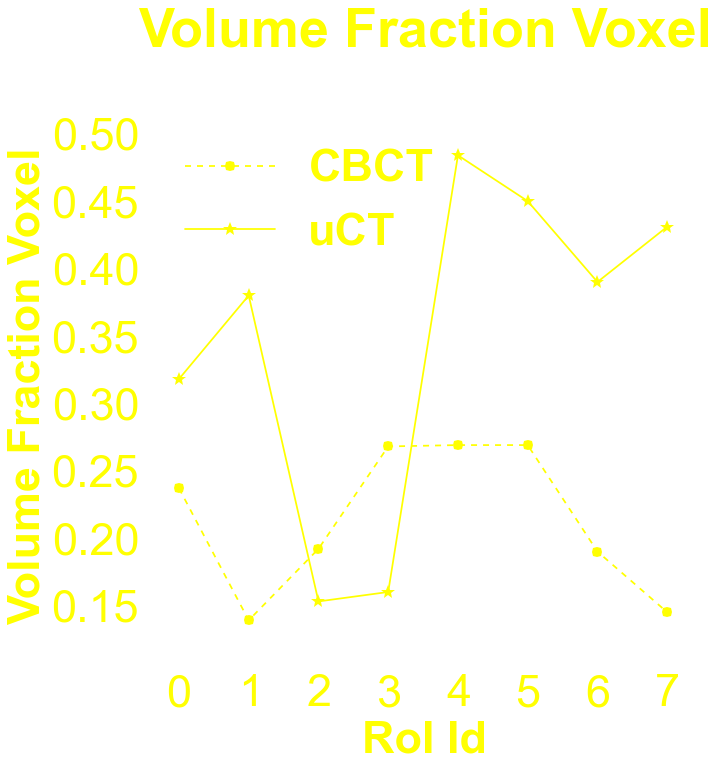

In [204]:
graphResultFolder = r'J:\Projects\JHUTrabeculae\Results\uCTvsCBCT_RoISelectedWojtek\ConferenceResults\Metrics'


varToShow = [12,13,14,50,61,64,69,70]

color = 'yellow'
fontsize = 45
for var in varToShow:
    varName = subdata.columns.values[var]
    
    subdata_uCT = datamatrix[(datamatrix['Image origin'] == 'uCT') & (datamatrix[varName].notnull())]
    subdata_CBCT = datamatrix[(datamatrix['Image origin'] == 'CBCT')& (datamatrix[varName].notnull())]
    
    
    RoINumbers = subdata_uCT['RoI Number'].values.astype(int)
    
    rangeLimY = np.max([subdata_uCT[varName].values,subdata_CBCT[varName].values]) - \
                np.min([subdata_uCT[varName].values,subdata_CBCT[varName].values])
    
    limY = [np.min([subdata_uCT[varName].values,subdata_CBCT[varName].values]) - rangeLimY * 0.1,
            np.max([subdata_uCT[varName].values,subdata_CBCT[varName].values]) + rangeLimY * 0.1]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.plot(RoINumbers,subdata_uCT[varName].values, c=color, markersize = 10, ls = '--', marker='o')
    ax.plot(RoINumbers,subdata_CBCT[varName].values,  c=color, markersize = 15, marker='*')
    ax.set_xlabel('RoI Id', fontsize=fontsize,fontweight="bold", color = color)
    ax.set_ylabel(varName, fontsize=fontsize,fontweight="bold", color = color)
    ax.set_title(varName + '\n', fontsize=fontsize*1.2,fontweight="bold", color = color)
    ax.set_axis_bgcolor('white')
    ax.tick_params(axis='x', labelsize=fontsize, color = color)
    ax.tick_params(axis='y', labelsize=fontsize, color = color)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.set_xlim([-0.5,7.5])
    ax.set_ylim(limY)
    leg = ax.legend(labels=['CBCT','uCT'], fontsize=fontsize, loc='best')
    ax.grid(b=False)

    for text in leg.get_texts():
        text.set_color(color)
        text.set_weight('bold')
    
    #(labels=['MDCT','uCT'])
    
    # Save results
    resultfile = graphResultFolder + r'/'+varName+'_VsRoINumber_line_yellow.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)

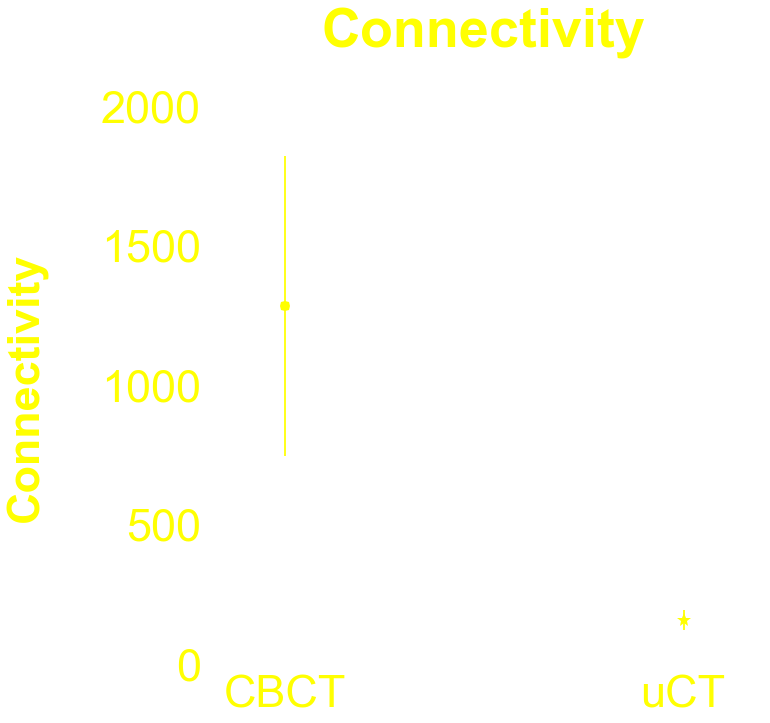

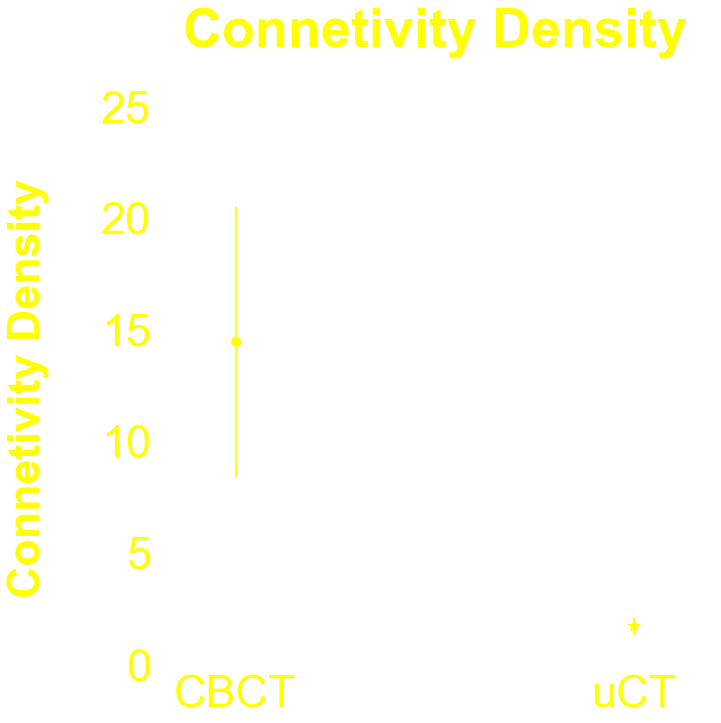

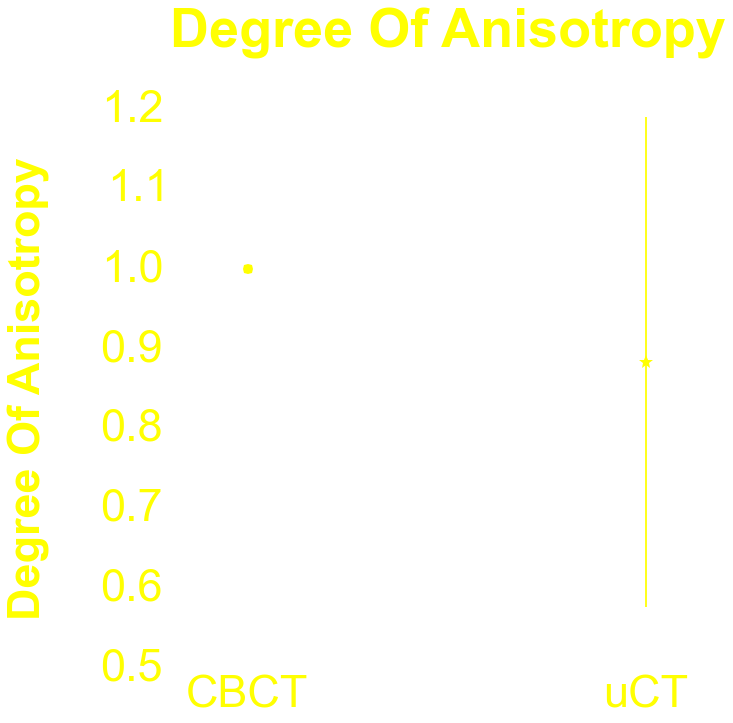

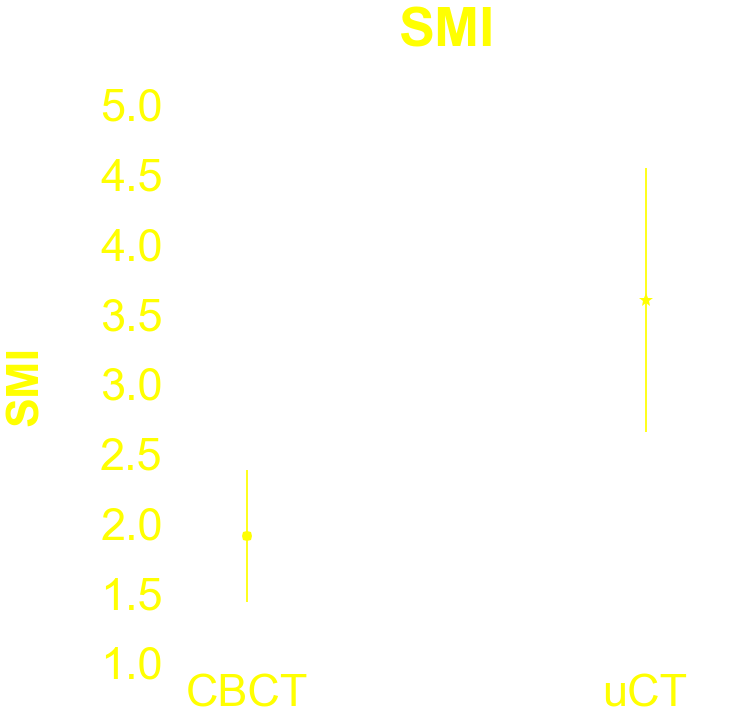

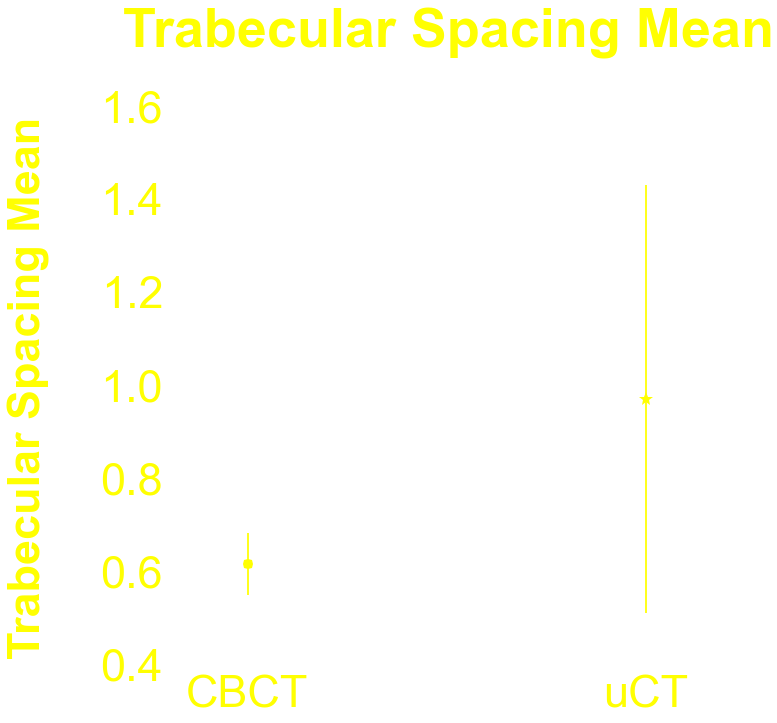

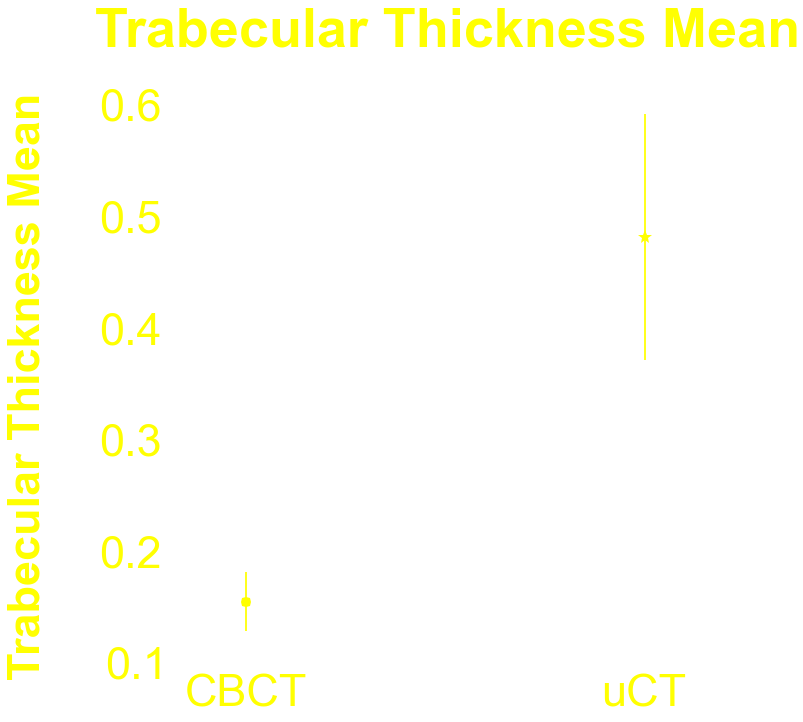

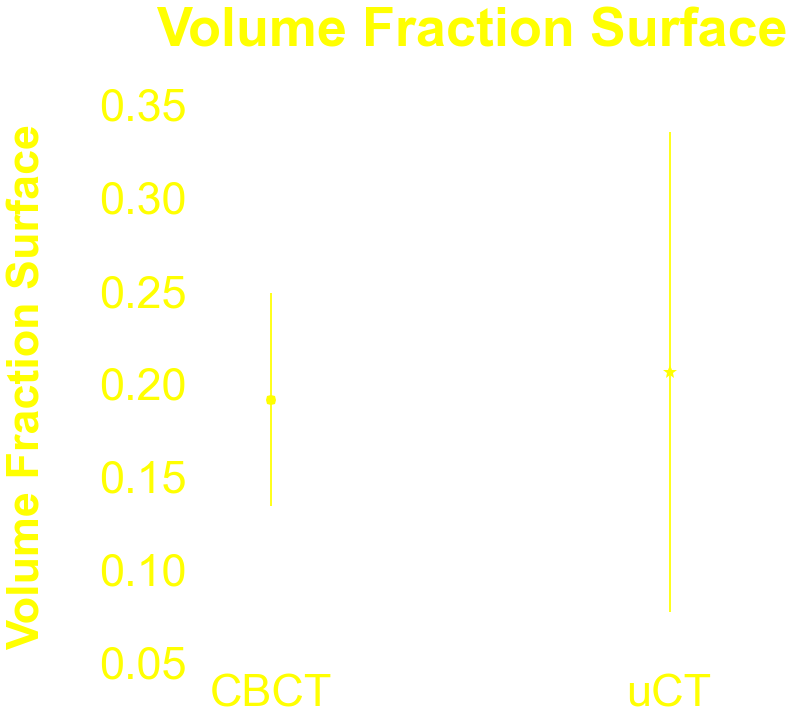

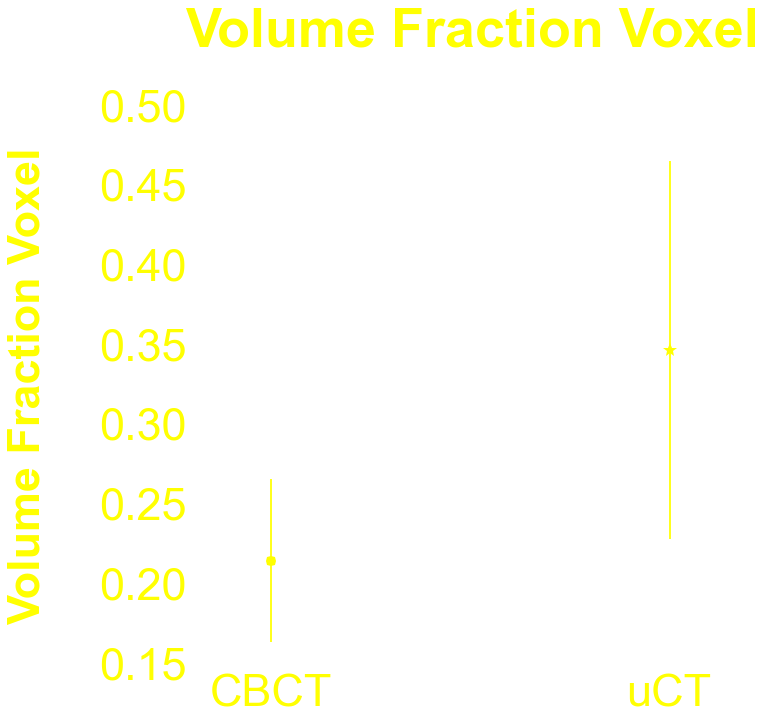

In [215]:
graphResultFolder = r'J:\Projects\JHUTrabeculae\Results\uCTvsCBCT_RoISelectedWojtek\ConferenceResults\Metrics'


varToShow = [12,13,14,50,61,64,69,70]

color = 'yellow'
for var in varToShow:
    varName = subdata.columns.values[var]
    
    subdata_uCT = datamatrix[(datamatrix['Image origin'] == 'uCT') & (datamatrix[varName].notnull())]
    subdata_CBCT = datamatrix[(datamatrix['Image origin'] == 'CBCT')& (datamatrix[varName].notnull())]
    
    
    RoINumbers = subdata_uCT['RoI Number'].values.astype(int)
    
    rangeLimY = np.max([subdata_uCT[varName].values + subdata_uCT[varName].values.std(),\
                        subdata_CBCT[varName].values] + subdata_CBCT[varName].values.std()) - \
                np.min([subdata_uCT[varName].values - subdata_uCT[varName].values.std(),subdata_CBCT[varName].values])
    
    limY = [np.min([subdata_uCT[varName].values,subdata_CBCT[varName].values]) - rangeLimY * 0.1,
            np.max([subdata_uCT[varName].values,subdata_CBCT[varName].values]) + rangeLimY * 0.1]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.errorbar(0,subdata_uCT[varName].values.mean(),yerr=subdata_uCT[varName].values.std(),  c=color, marker='o', markersize = 10, ls = '--')
    ax.errorbar(1,subdata_CBCT[varName].values.mean(),yerr=subdata_CBCT[varName].values.std(),  c=color, marker='*', markersize = 15)
    
    plt.xticks([0,1], ['CBCT','uCT'])
    ax.set_xlabel('', fontsize=27,fontweight="bold",color = color)
    ax.set_ylabel(varName + '\n', fontsize=fontsize,fontweight="bold",color = color)
    ax.set_axis_bgcolor('white')
    ax.tick_params(axis='x', labelsize=fontsize, color = color)
    ax.tick_params(axis='y', labelsize=fontsize, color = color)
    ax.set_xlim([-0.2,1.2])
    #ax.set_ylim(limY)
    ax.tick_params(axis='x', colors=color)
    ax.tick_params(axis='y', colors=color)
    ax.set_title(varName + '\n', fontsize=fontsize*1.2,fontweight="bold", color = color)
    ax.grid(b=False)

    
    # Save results
    resultfile = graphResultFolder + r'/'+varName+'Metric_yellow.png'
    #resultfile = graphResultFolder + r'/'+varName+'VsRoISize.pdf'
    plt.savefig(resultfile,bbox_inches='tight',transparent=True)